# TM10007 Assignment template -- ECG data

## Data loading and cleaning

Below are functions to load the dataset of your choice. After that, it is all up to you to create and evaluate a classification method. Beware, there may be missing values in these datasets. Good luck!

In [1]:
# # Run this to use from colab environment
# !git clone https://github.com/jveenland/tm10007_ml.git

# import zipfile
# import os
# import pandas as pd

# with zipfile.ZipFile('/content/tm10007_ml/ecg/ecg_data.zip', 'r') as zip_ref:
#     zip_ref.extractall('/content/tm10007_ml/ecg')

# data = pd.read_csv('/content/tm10007_ml/ecg/ecg_data.csv', index_col=0)

# print(f'The number of samples: {len(data.index)}')
# print(f'The number of columns: {len(data.columns)}')

In [67]:
# Run this to use from colab environment
# !git clone https://github.com/jveenland/tm10007_ml.git

# Standard libraries
import os
import zipfile
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from matplotlib.colors import Normalize
import seaborn as sns

# Statistical tools
from scipy.stats import zscore, normaltest, shapiro

# Scikit-learn
from sklearn import metrics
from sklearn.model_selection import StratifiedKFold, RandomizedSearchCV, train_test_split, learning_curve, cross_val_score
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler, RobustScaler, PowerTransformer
from sklearn.metrics import RocCurveDisplay, roc_auc_score, accuracy_score, precision_score, recall_score, f1_score
from sklearn.feature_selection import SelectKBest, RFECV, RFE, f_classif, mutual_info_classif

# Classifiers and dimensionality reduction
from sklearn.ensemble import RandomForestClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.svm import SVC
from sklearn.linear_model import LogisticRegression
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis
from sklearn.decomposition import PCA

# Load data
with zipfile.ZipFile(os.path.join('tm10007_ml','ecg','ecg_data.zip'), 'r') as zip_ref:
    zip_ref.extractall('/content/tm10007_ml/ecg')

data = pd.read_csv('/content/tm10007_ml/ecg/ecg_data.csv', index_col=0)

print(f'The number of samples: {len(data.index)}')
print(f'The number of columns: {len(data.columns)}')

# Set RandomState for the entire script
np.random.seed(24)

The number of samples: 827
The number of columns: 9001


In [68]:
# Load functions
def plot_learning_curve(X_train, y_train, classifier, scoring, clf_type):
    '''
    This function plots the learning curve of a classifier using a 5-fold cross-validation
    Inputs:
    - X_train: 
    - y_train: labels
    - classifier: fitted classifier
    - scoring: supports all scoring methods from https://scikit-learn.org/stable/modules/generated/sklearn.model_selection.learning_curve.html 
    and the 'error' scoring method, which is 1-accuracy
    - clf_type: is used for the title of the plot
    '''
    if scoring == 'error':
        train_sizes, train_scores, test_scores = learning_curve(
            classifier,
            X_train,
            y_train,
            cv=StratifiedKFold(n_splits=5, shuffle=True, random_state=42),
            scoring='accuracy',
            train_sizes=np.linspace(0.1, 1.0, 50),
            n_jobs=-1,
        )
        train_scores_mean = 1-np.mean(train_scores, axis=1) # error = 1 - accuracy
        train_scores_std = np.std(train_scores, axis=1)
        test_scores_mean = 1-np.mean(test_scores, axis=1) # error = 1 - accuracy
        test_scores_std = np.std(test_scores, axis=1)
    else:
        train_sizes, train_scores, test_scores = learning_curve(
            classifier,
            X_train,
            y_train,
            cv=StratifiedKFold(n_splits=5, shuffle=True, random_state=42),
            scoring=scoring,
            train_sizes=np.linspace(0.1, 1.0, 50),
            n_jobs=-1,
        )
        train_scores_mean = np.mean(train_scores, axis=1)
        train_scores_std = np.std(train_scores, axis=1)
        test_scores_mean = np.mean(test_scores, axis=1)
        test_scores_std = np.std(test_scores, axis=1)

    # Plot figure
    plt.figure(figsize=(10, 6))
    plt.title(f"Learning Curve ({clf_type})")
    plt.xlabel("Number of training objects")
    plt.ylabel(scoring)

    plt.grid()

    plt.plot(train_sizes, train_scores_mean, 'o-', label="Training score", color="blue")
    plt.fill_between(train_sizes, train_scores_mean - train_scores_std,
                    train_scores_mean + train_scores_std, alpha=0.1, color="blue")

    plt.plot(train_sizes, test_scores_mean, 'o-', label="Cross-validation score", color="green")
    plt.fill_between(train_sizes, test_scores_mean - test_scores_std,
                    test_scores_mean + test_scores_std, alpha=0.1, color="green")

    plt.legend(loc="best")
    if scoring =='error':
        plt.ylim([-0.01, 0.5])
    elif scoring == "roc_auc":
        plt.ylim([0.5, 1.01])
    plt.tight_layout()
    plt.show()

def plot_roc_cv(X, y, hyperparams_function, n_splits=5):
    '''
    Performs a cross validation to train a number of models (equal to n_splits), calculates relevant metrics and plots the mean ROC curve.
    Returns the best classifier out of the folds with the corresponding training data
    '''
    y = data.iloc[:,-1]
    X = data.iloc[:,:-1]

    cv = StratifiedKFold(n_splits=n_splits, shuffle=True, random_state=42)

    tprs = []
    aucs = []
    best_classifier = None
    best_auc = 0.0
    mean_fpr = np.linspace(0, 1, 100)

    fig, ax = plt.subplots(figsize=(6, 6))
    for fold, (train, test) in enumerate(cv.split(X, y)):
        X_train = X.iloc[train]
        y_train = y.iloc[train]
        X_test = X.iloc[test]
        y_test = y.iloc[test]
        classifier = hyperparams_function(X_train, y_train)
        viz = RocCurveDisplay.from_estimator(
            classifier,
            X_test,
            y_test,
            name=f"ROC fold {fold}",
            alpha=0.3,
            lw=1,
            ax=ax,
            plot_chance_level=(fold == n_splits - 1),
        )
        interp_tpr = np.interp(mean_fpr, viz.fpr, viz.tpr)
        interp_tpr[0] = 0.0
        tprs.append(interp_tpr)
        aucs.append(viz.roc_auc)

        if viz.roc_auc > best_auc:
            best_auc = viz.roc_auc
            best_classifier = classifier
            best_X_train = X_train
            best_y_train = y_train

        y_pred = classifier.predict(X_test)
        y_proba = classifier.predict_proba(X_test)[:, 1]

        accuracy = accuracy_score(y_test, y_pred)
        precision = precision_score(y_test, y_pred, zero_division=0)
        recall = recall_score(y_test, y_pred, zero_division=0)
        f1 = f1_score(y_test, y_pred, zero_division=0)
        fold_auc = roc_auc_score(y_test, y_proba)

        print(f"Accuracy:  {accuracy:.3f}")
        print(f"Precision: {precision:.3f}")
        print(f"Recall:    {recall:.3f}")
        print(f"F1 Score:  {f1:.3f}")
        print(f"AUC Score: {fold_auc:.3f}")

    mean_tpr = np.mean(tprs, axis=0)
    mean_tpr[-1] = 1.0
    mean_auc = metrics.auc(mean_fpr, mean_tpr)
    std_auc = np.std(aucs)
    ax.plot(
        mean_fpr,
        mean_tpr,
        color="b",
        label=r"Mean ROC (AUC = %0.2f $\pm$ %0.2f)" % (mean_auc, std_auc),
        lw=2,
        alpha=0.8,
    )

    std_tpr = np.std(tprs, axis=0)
    tprs_upper = np.minimum(mean_tpr + std_tpr, 1)
    tprs_lower = np.maximum(mean_tpr - std_tpr, 0)
    ax.fill_between(
        mean_fpr,
        tprs_lower,
        tprs_upper,
        color="grey",
        alpha=0.2,
        label=r"$\pm$ 1 std. dev.",
    )

    ax.set(
        xlabel="False Positive Rate",
        ylabel="True Positive Rate",
        title=f"Mean ROC curve with variability",
    )
    ax.legend(loc="lower right")
    plt.show()
    return best_X_train, best_y_train, best_classifier


# Data visualisation

Number of healthy samples: 681
Total number of samples: 827


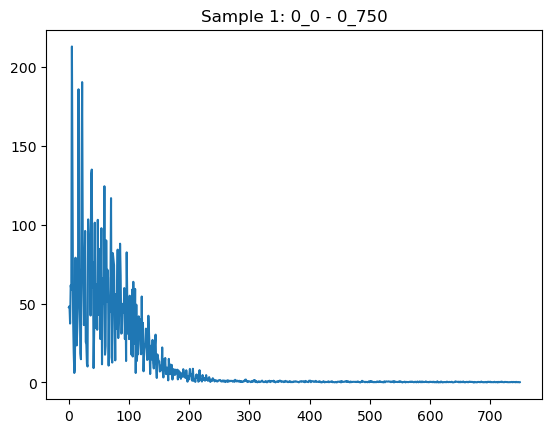

In [4]:
# print number of sick and not sick
count = 0
for label in data.iloc[:,-1]:
    if label == 0:
        count += 1

print(f"Number of healthy samples: {count}")
print(f"Total number of samples: {len(data.iloc[:,-1])}")

# All data of sample 1, lead 1 was plotted to get a quick overview of the data
fig, ax = plt.subplots(1,1)
ax.plot(range(0,750), data.iloc[0,0:750])
ax.set_title('Sample 1: 0_0 - 0_750')
plt.show()

Check for zero values in dataset for possible log transform

In [5]:
# Check if there are any zero values in the entire DataFrame
zero_values = (data.iloc[:,:-1] == 0)
print("Zero values present in the DataFrame:\n", zero_values)

# Count the number of zero values
num_zero_values = zero_values.sum().sum()
print(f"Total number of zero values: {num_zero_values}")

Zero values present in the DataFrame:
        0_0    0_1    0_2    0_3    0_4    0_5    0_6    0_7    0_8    0_9  \
0    False  False  False  False  False  False  False  False  False  False   
1    False  False  False  False  False  False  False  False  False  False   
2    False  False  False  False  False  False  False  False  False  False   
3    False  False  False  False  False  False  False  False  False  False   
4    False  False  False  False  False  False  False  False  False  False   
..     ...    ...    ...    ...    ...    ...    ...    ...    ...    ...   
822  False  False  False  False  False  False  False  False  False  False   
823  False  False  False  False  False  False  False  False  False  False   
824  False  False  False  False  False  False  False  False  False  False   
825  False  False  False  False  False  False  False  False  False  False   
826  False  False  False  False  False  False  False  False  False  False   

     ...  11_740  11_741  11_742  11

Normal Features: 0
Non-Normal Features: 9001
Transformed Normal Features: 300
Transformed Non-Normal Features: 8701


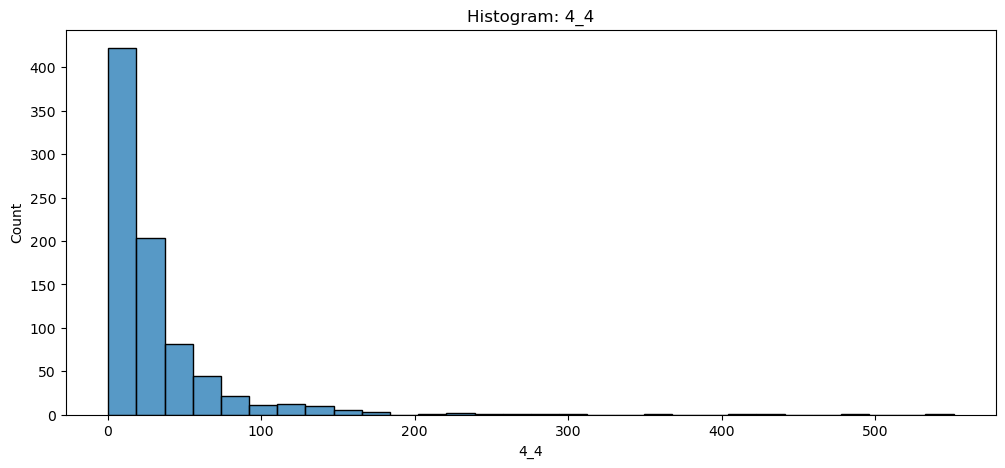

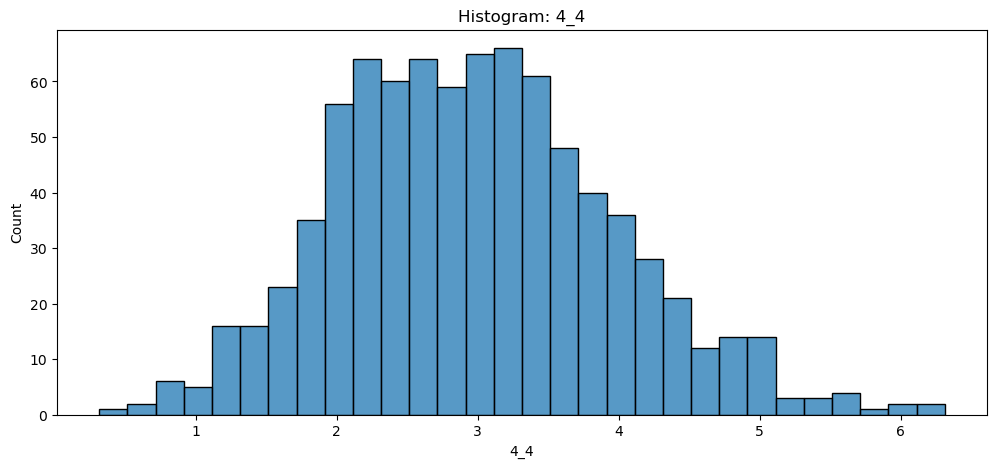

In [6]:
normal_features = []
non_normal_features = []

for feature in data.columns:
    stat, p = shapiro(data[feature]) # Or use normaltest()
    if p > 0.05:
        normal_features.append(feature)
    else:
        non_normal_features.append(feature)

print(f"Normal Features: {len(normal_features)}")
print(f"Non-Normal Features: {len(non_normal_features)}")

t_normal_features = []
t_non_normal_features = []
data_transformed = np.log1p(data)
for feature in data_transformed.columns:
    stat, p = shapiro(data_transformed[feature]) # Or use normaltest()
    if p > 0.05:
        t_normal_features.append(feature)
    else:
        t_non_normal_features.append(feature)

print(f"Transformed Normal Features: {len(t_normal_features)}")
print(f"Transformed Non-Normal Features: {len(t_non_normal_features)}")


def plot_normality(feature_data, feature_name):
    plt.figure(figsize=(12, 5))
    
    # Histogram
    plt.plot()
    sns.histplot(feature_data, bins=30)
    plt.title(f"Histogram: {feature_name}")

    plt.show()

plot_normality(data['4_4'], '4_4')
plot_normality(data_transformed['4_4'], '4_4')

(207, 9000)
(620, 9000)


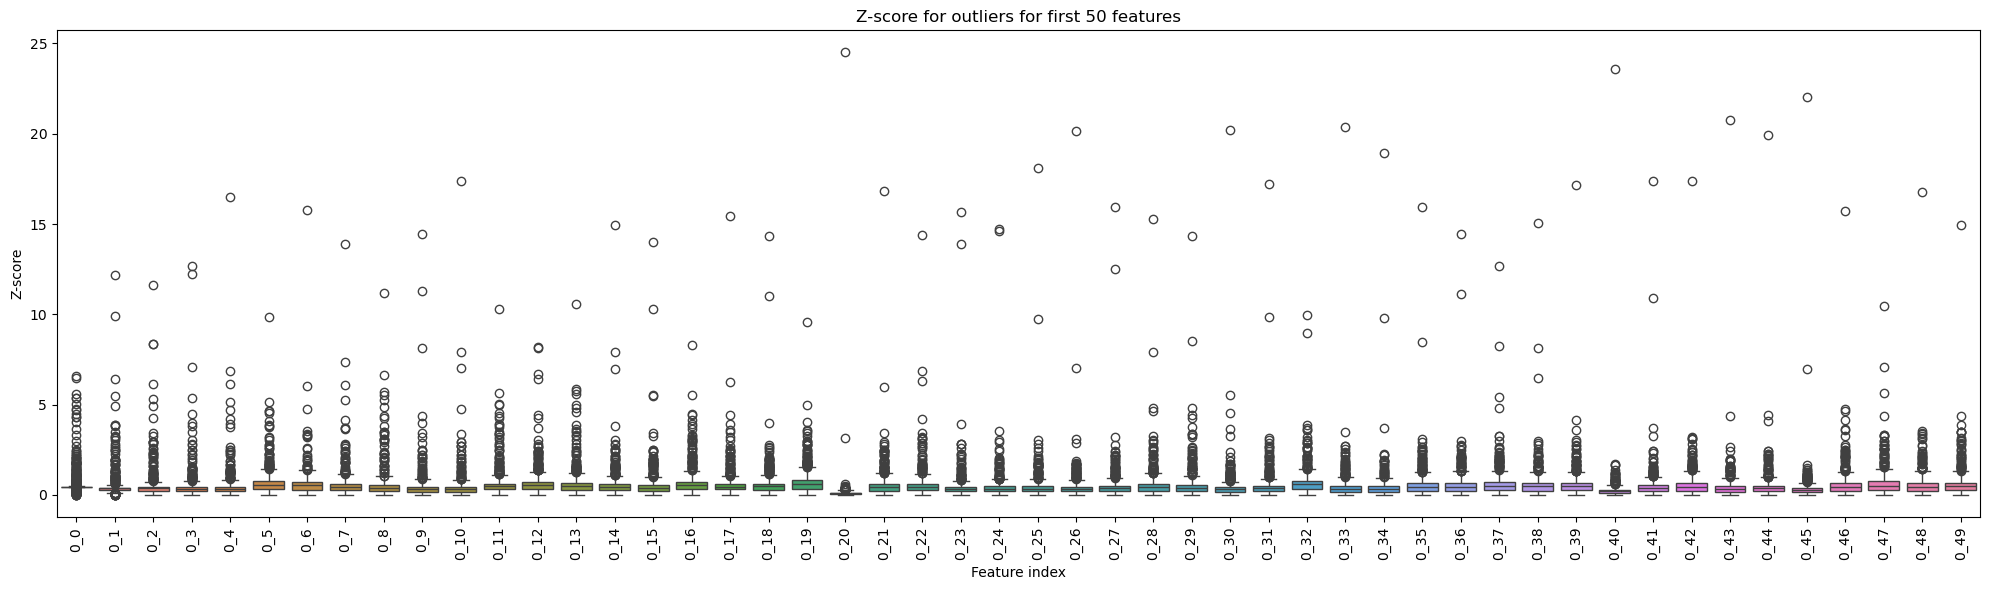

In [7]:
# The following code was used to check whether the data contained outliers. 
# This was done by plotting the Z-score for the first 50 features.
# From the resulting plot, it can be concluded that there are outliers (Z-score > 3) 
# and that the data should be scaled before training classifiers that are sensitive to outliers
labels = data.iloc[:,-1]
x = data.iloc[:,:-1]

X_train, X_test, y_train, y_test = train_test_split(x, labels, test_size=0.25, stratify=labels, random_state=42)
print(X_test.shape)
print(X_train.shape)

#Preprocessing, scaling: outliers plotten for first 50 features
X_subset = X_train.iloc[:, :50]
z_scores = np.abs(zscore(X_subset))

plt.figure(figsize=(20, 6))
sns.boxplot(data=pd.DataFrame(z_scores, columns=X_subset.columns))
plt.title("Z-score for outliers for first 50 features")
plt.xlabel("Feature index")
plt.ylabel("Z-score")
plt.xticks(rotation=90)
plt.tight_layout()
plt.show()

Check outliers after powertransform

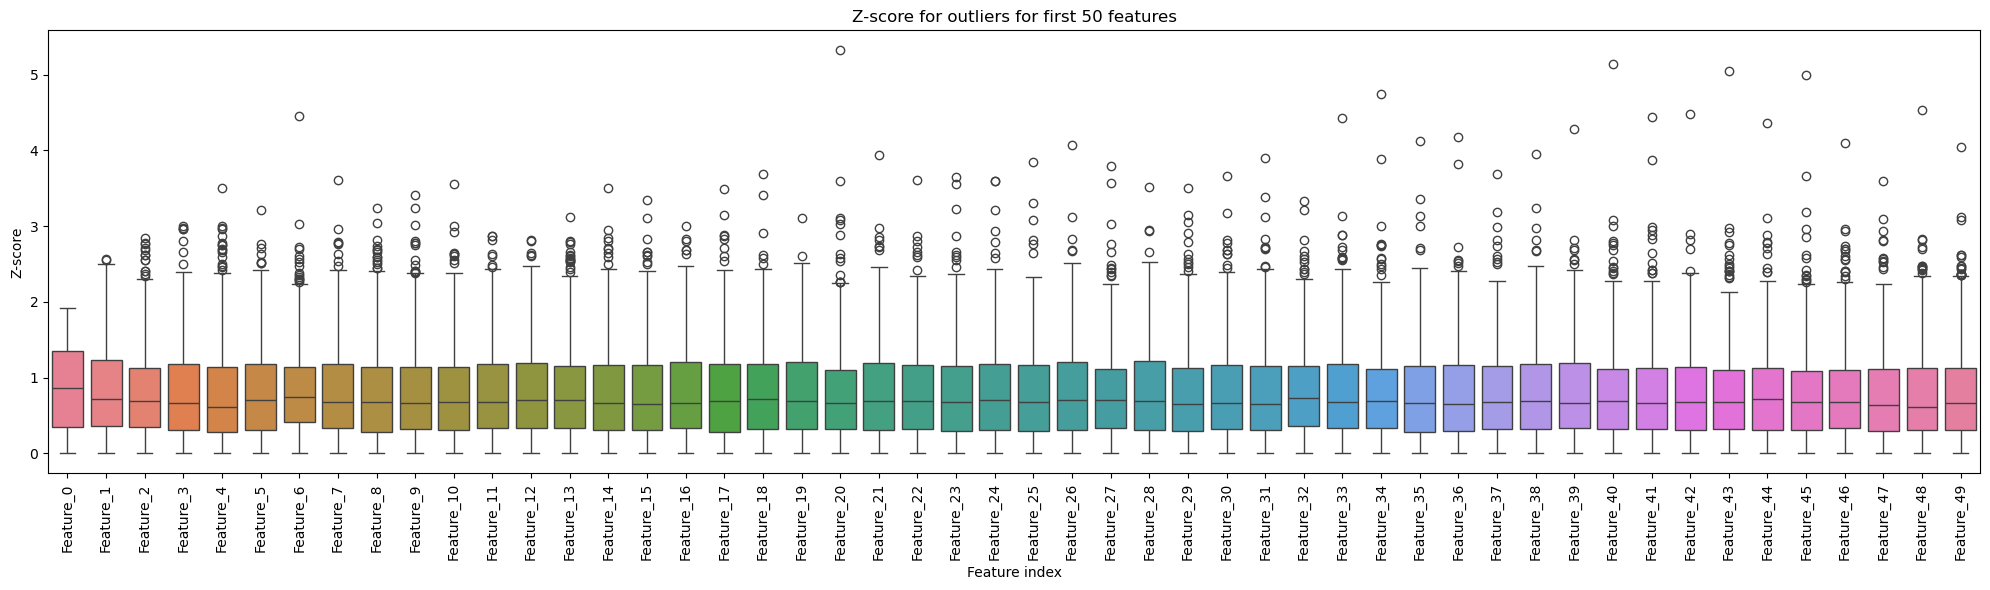

In [8]:
power_transformer = PowerTransformer(method='yeo-johnson')
X_train_transformed = power_transformer.fit_transform(X_train)
X_test_transformed = power_transformer.transform(X_test)

X_subset = X_train_transformed[:, :50]
z_scores = np.abs(zscore(X_subset))

z_df = pd.DataFrame(z_scores, columns=[f'Feature_{i}' for i in range(X_subset.shape[1])])

plt.figure(figsize=(20, 6))
sns.boxplot(data=z_df)
plt.title("Z-score for outliers for first 50 features")
plt.xlabel("Feature index")
plt.ylabel("Z-score")
plt.xticks(rotation=90)
plt.tight_layout()
plt.show()

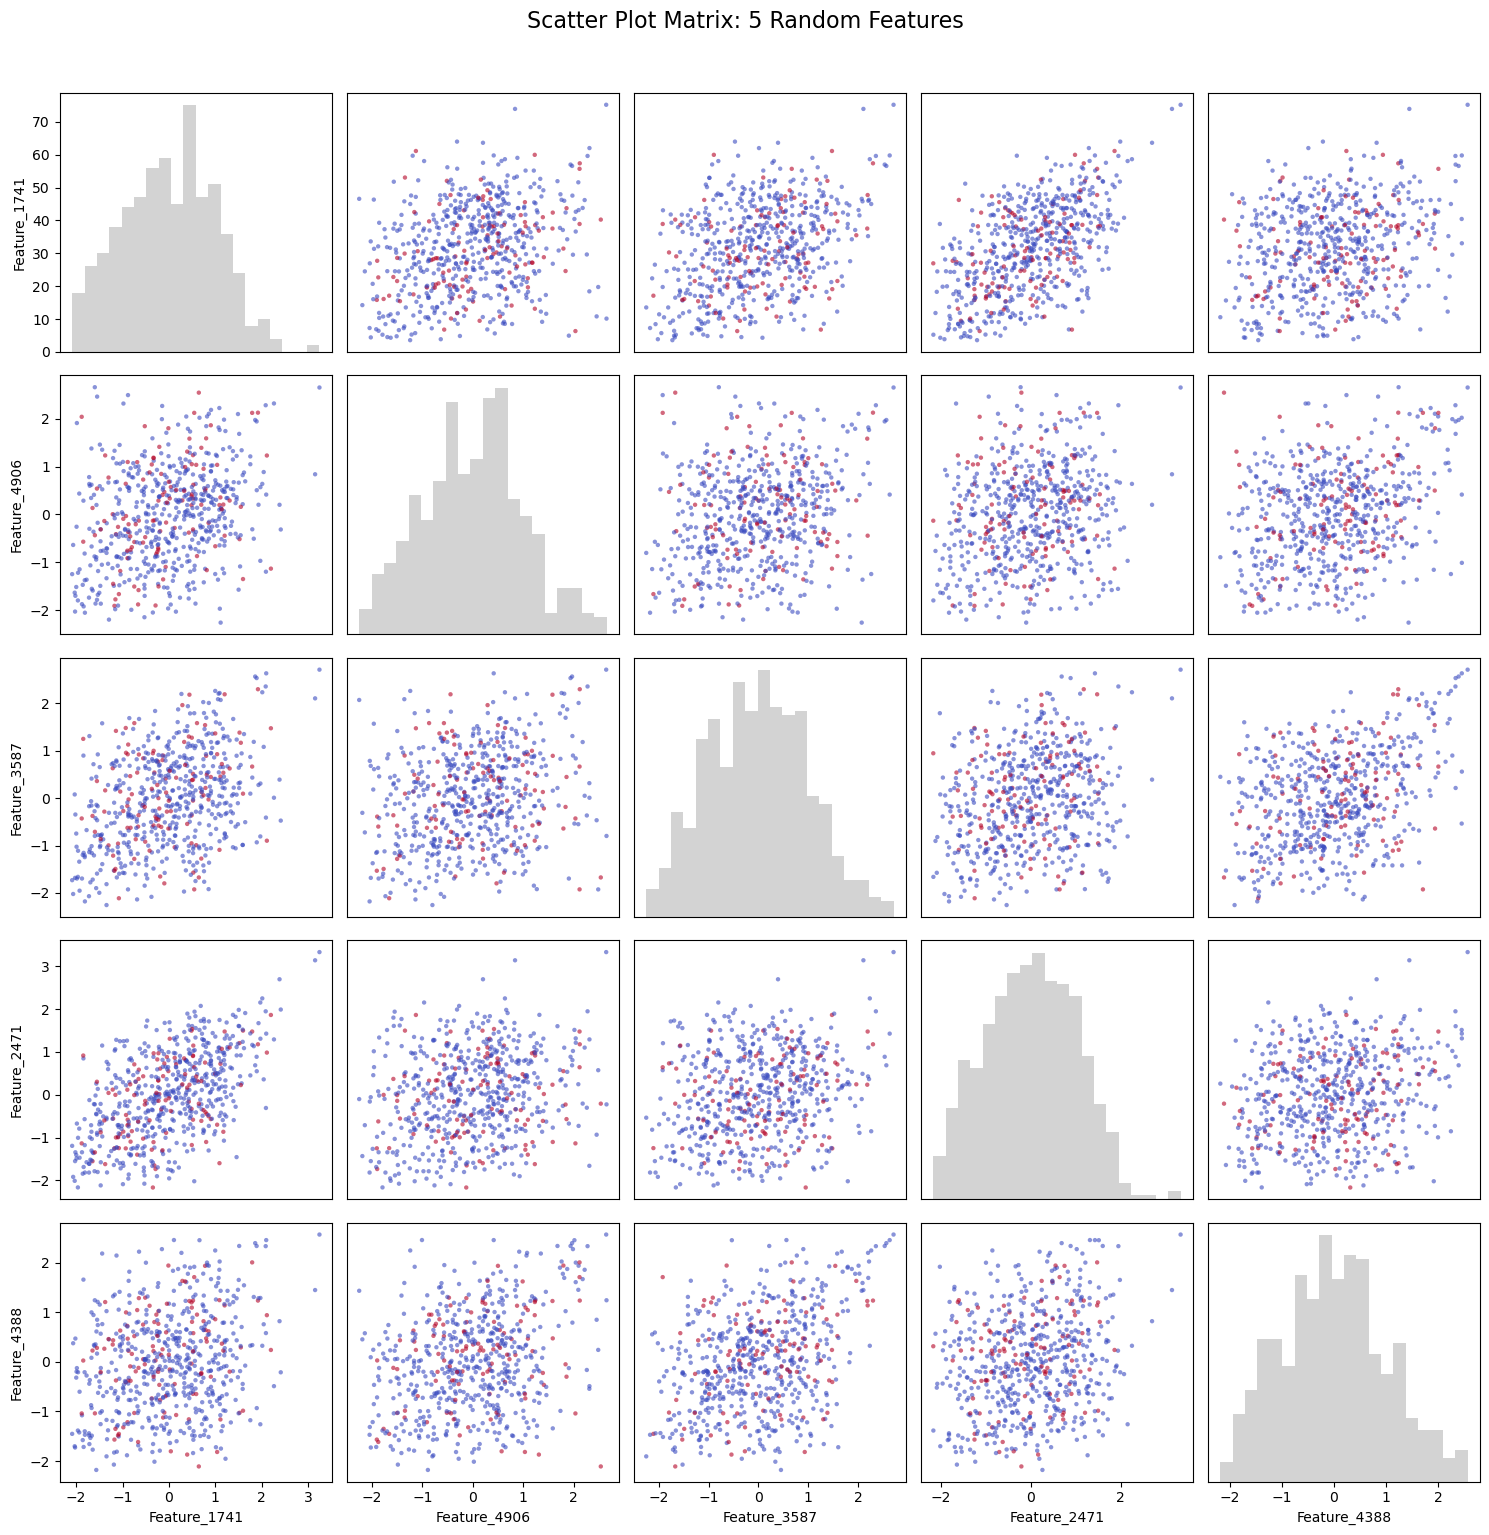

In [45]:
# Check distribution of data after powertransform
# Pick 5 random features
random_features = np.random.choice(X_train_transformed.shape[1], size=5, replace=False)

# Subset the data
X_subset = X_train_transformed[:, random_features]
feature_names = [f'Feature_{i}' for i in random_features]

# Create figure
fig, axes = plt.subplots(5, 5, figsize=(15, 15))
fig.suptitle("Scatter Plot Matrix: 5 Random Features", fontsize=16, y=1.02)

# Fill the grid
for i in range(5):
    for j in range(5):
        ax = axes[i, j]
        if i == j:
            # Plot histogram on the diagonal
            ax.hist(X_subset[:, i], bins=20, color='lightgray')
        else:
            # Scatter plot
            ax.scatter(
                X_subset[:, j], X_subset[:, i],
                c=y_train, cmap='coolwarm', s=10, alpha=0.6, edgecolors='none'
            )
        if i == 4:
            ax.set_xlabel(feature_names[j])
        else:
            ax.set_xticks([])
        if j == 0:
            ax.set_ylabel(feature_names[i])
        else:
            ax.set_yticks([])

plt.tight_layout()
plt.show()

### Unused code for normality analysis

In [3]:
labels = data.iloc[:,-1]
x = data.iloc[:,:-1]

X_train, X_test, y_train, y_test = train_test_split(x, labels, test_size=0.25, stratify=labels, random_state=42)

In [29]:
# How many features are normally distributed with and without transformation?
normal_features = []
non_normal_features = []

for feature in X_train.columns:  
    stat, p = shapiro(X_train[feature])
    if p > 0.05:
        normal_features.append(feature)
    else:
        non_normal_features.append(feature)

print(f"Normal Features: {len(normal_features)}")
print(f"Non-Normal Features: {len(non_normal_features)}")

t_normal_features = []
t_non_normal_features = []

data_transformed = np.log1p(X_train)
for feature in data_transformed.columns: 
    stat, p = shapiro(data_transformed[feature])  
    if p > 0.05:
        t_normal_features.append(feature)
    else:
        t_non_normal_features.append(feature)

print(f"Transformed Normal Features: {len(t_normal_features)}")
print(f"Transformed Non-Normal Features: {len(t_non_normal_features)}")

Normal Features: 0
Non-Normal Features: 9000
Transformed Normal Features: 400
Transformed Non-Normal Features: 8600


Look at correlation heatmap to see if PCA is needed

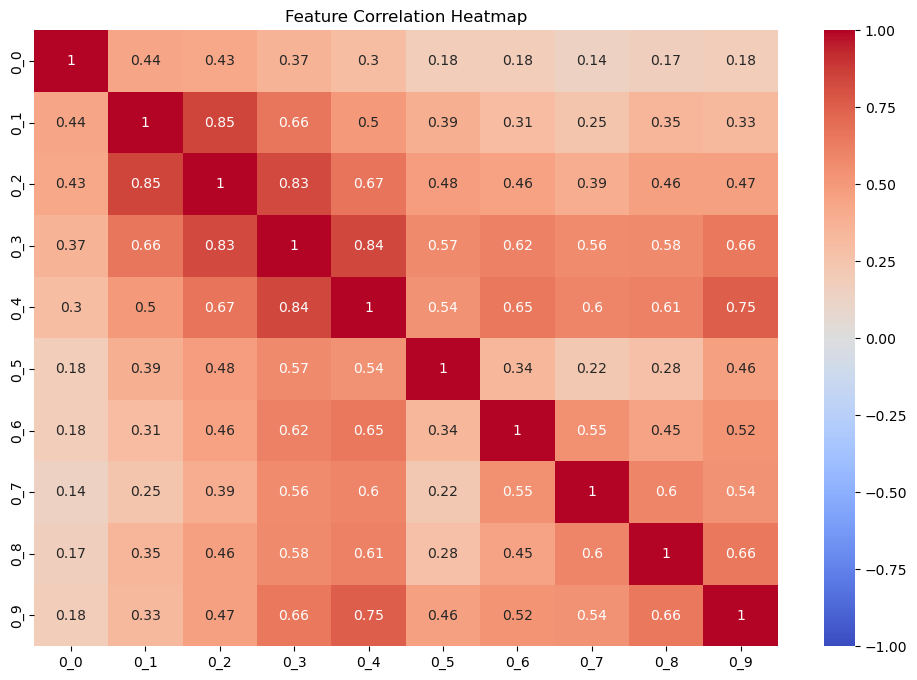

In [30]:
# Compute correlation matrix
correlation_matrix = X_train.corr()

plt.figure(figsize=(12, 8))
sns.heatmap(correlation_matrix.iloc[:10, :10], cmap="coolwarm", center=0, vmin=-1, vmax=1, annot=True)
plt.title("Feature Correlation Heatmap")
plt.show()

Look at QDA when scaling is applied

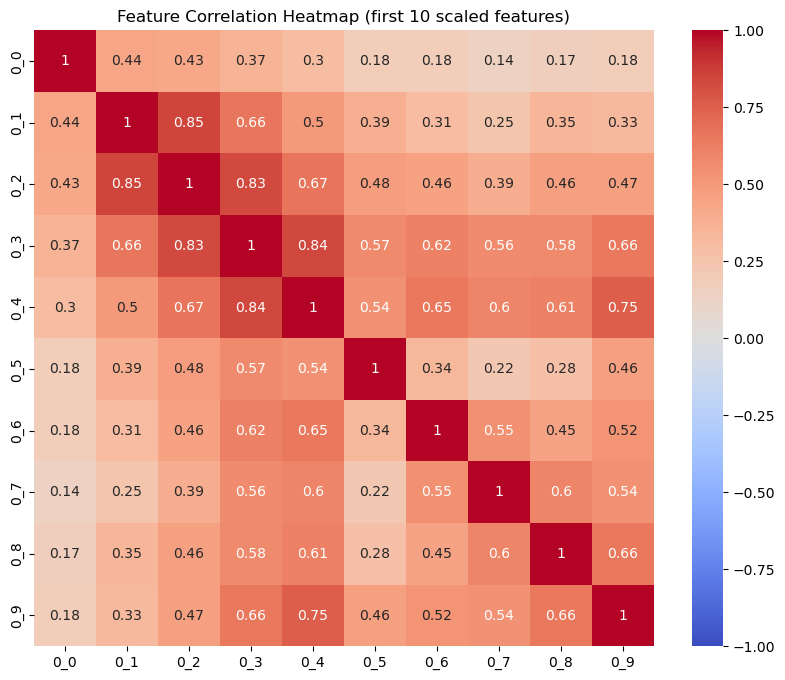

In [31]:
# Standard scaling
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)

# Heatmap van correlaties op geschaalde data (eerste 10 features)
X_train_scaled_df = pd.DataFrame(X_train_scaled, columns=X_train.columns)
correlation_matrix = X_train_scaled_df.iloc[:, :10].corr()

plt.figure(figsize=(10, 8))
sns.heatmap(correlation_matrix, cmap="coolwarm", center=0, vmin=-1, vmax=1, annot=True)
plt.title("Feature Correlation Heatmap (first 10 scaled features)")
plt.show()

# PCA - retain 95% variance
pca = PCA(n_components=0.95)
X_train_pca = pca.fit_transform(X_train_scaled)


In [32]:
# PCA without scaling
pca_unscaled = PCA(n_components=0.95)
X_train_pca_unscaled = pca_unscaled.fit_transform(X_train)

print("Aantal componenten met scaling:", X_train_pca.shape[1])
print("Aantal componenten zonder scaling:", X_train_pca_unscaled.shape[1])


Aantal componenten met scaling: 113
Aantal componenten zonder scaling: 14


When selecting the best 400 features are these normally distributed? Method: mutual_info_classif and RFECV

In [35]:
# Select top 400 features with the highest F-statistic
selector = SelectKBest(score_func=mutual_info_classif, k=400)
X_train_selected = selector.fit_transform(X_train, y_train)

# Use LDA as the estimator (since it's similar to QDA but more stable for feature selection)
lda = LinearDiscriminantAnalysis()  # LDA as a baseline for QDA

# Cross-validation
cv = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)

rfecv = RFECV(estimator=lda, step=1, cv=cv, scoring='accuracy', n_jobs=-1)
X_train_final = rfecv.fit_transform(X_train_selected, y_train)
X_train_final = np.log1p(X_train_final)

# Check normality
normal_features = []
non_normal_features = []

for feature in range(X_train_final.shape[1]):
    stat, p = shapiro(X_train_final[:, feature])
    if p > 0.05:
        normal_features.append(feature)
    else:
        non_normal_features.append(feature)

print(f"Normal Features: {len(normal_features)}")
print(f"Non-Normal Features: {len(non_normal_features)}")

Normal Features: 0
Non-Normal Features: 7


When selecting the best 400 features are these normally distributed? Method: mutual_info_classif and RFE

In [34]:
# Select top 400 features with the highest F-statistic
selector = SelectKBest(score_func=mutual_info_classif, k=400)
X_train_selected = selector.fit_transform(X_train, y_train)

# Use LDA as the estimator (since it's similar to QDA but more stable for feature selection)
lda = LinearDiscriminantAnalysis()  # LDA as a baseline for QDA

rfe = RFE(estimator=lda, n_features_to_select=100)
X_train_final = rfe.fit_transform(X_train_selected, y_train)
X_train_final = np.log1p(X_train_final)

# Check normality
normal_features = []
non_normal_features = []

for feature in range(X_train_final.shape[1]):
    stat, p = shapiro(X_train_final[:, feature])
    if p > 0.05:
        normal_features.append(feature)
    else:
        non_normal_features.append(feature)

print(f"Normal Features: {len(normal_features)}")
print(f"Non-Normal Features: {len(non_normal_features)}")

Normal Features: 0
Non-Normal Features: 100


# SVM

In [69]:
# Split data in test and train, do this once
labels = data.iloc[:,-1]
x = data.iloc[:,:-1]

X_train, X_test, y_train, y_test = train_test_split(x, labels, test_size=0.25, stratify=labels, random_state=12)

# ====== PIPELINE CHARACTERISTICS ======
cv = StratifiedKFold(n_splits=5, shuffle=True, random_state=12)
svm_feature = SVC(kernel="linear", random_state=12, class_weight='balanced')

With this code, a learning curve for robust and powertransform was made to make a choise between the scaling/transforming method

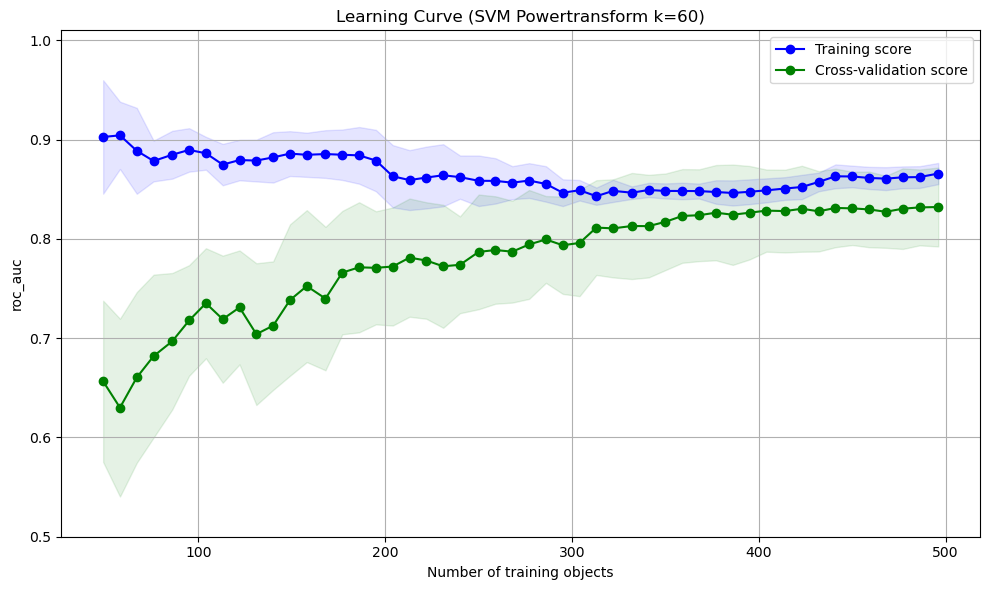

Mean ROC AUC powertransform: 0.832062321839592


In [42]:
# ====== Powertransformation ======
power_transformer = PowerTransformer(method='yeo-johnson')
X_train_transformed = power_transformer.fit_transform(X_train)
X_test_transformed = power_transformer.transform(X_test)

# ====== PRE-FEATURE SELECTION ======
# Use SelectKBest with mutual_info_classif for feature selection
selector = SelectKBest(mutual_info_classif, k=60)
X_train_reduced = selector.fit_transform(X_train_transformed, y_train)
X_test_reduced = selector.transform(X_test_transformed)

# ====== FEATURE SELECTION ======
svm = SVC(kernel="linear", random_state=42)
rfecv = RFECV(estimator=svm, step=5, cv=cv, scoring='roc_auc')
rfecv.fit(X_train_reduced, y_train)
X_selected = rfecv.transform(X_train_reduced)
X_test_selected = rfecv.transform(X_test_reduced)

# ====== PIPELINE CHARACTERISTICS ======
svm = SVC(kernel="linear", random_state=42)

# ====== PIPELINE  ======
pipeline = Pipeline([
    ('svm', svm)
])

# ====== EVALUATION  ======
scores = cross_val_score(
    pipeline,
    X_selected,
    y_train,
    cv=cv,
    scoring='roc_auc',
    n_jobs=-1
)

pipeline.fit(X_selected, y_train)

plot_learning_curve(X_selected, y_train, classifier=pipeline, scoring='roc_auc', clf_type='SVM Powertransform k=60')
print("Mean ROC AUC powertransform:", scores.mean())

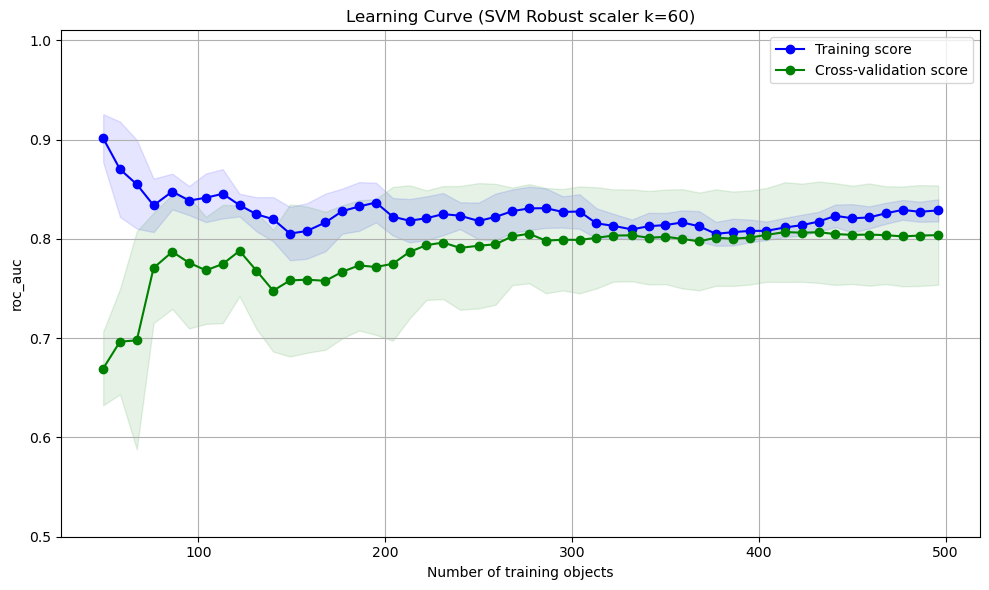

Mean ROC AUC robust scaler: 0.8037234134607065


In [43]:
# ====== Robust scaling ======
robust_scaler = RobustScaler()
X_train_transformed = robust_scaler.fit_transform(X_train)
X_test_transformed = robust_scaler.transform(X_test)

# ====== PRE-FEATURE SELECTION ======
# Use SelectKBest with mutual_info_classif for feature selection
selector = SelectKBest(mutual_info_classif, k=60)
X_train_reduced = selector.fit_transform(X_train_transformed, y_train)
X_test_reduced = selector.transform(X_test_transformed)

# ====== FEATURE SELECTION ======
svm = SVC(kernel="linear", random_state=42)
rfecv = RFECV(estimator=svm, step=5, cv=cv, scoring='roc_auc')
rfecv.fit(X_train_reduced, y_train)
X_selected = rfecv.transform(X_train_reduced)
X_test_selected = rfecv.transform(X_test_reduced)

# ====== PIPELINE CHARACTERISTICS ======
svm = SVC(kernel="linear", random_state=42)

# ====== PIPELINE  ======
pipeline = Pipeline([
    ('svm', svm)
])

# ====== EVALUATION  ======
scores = cross_val_score(
    pipeline,
    X_selected,
    y_train,
    cv=cv,
    scoring='roc_auc',
    n_jobs=-1
)

pipeline.fit(X_selected, y_train)

plot_learning_curve(X_selected, y_train, classifier=pipeline, scoring='roc_auc', clf_type='SVM Robust scaler k=60')
print("Mean ROC AUC robust scaler:", scores.mean())

To select the best k for SelectKBest, a learning curve is plotted for K=100, K=80, K=60, K=40 and K=20. In addition, the number of selected features after RFECV and the mean ROC AUC is printed. This is done with transformation and feature selection outside the pipeline, for computational reasons. 

In [59]:
# ====== Powertransformation ======
power_transformer = PowerTransformer(method='yeo-johnson')
X_train_transformed = power_transformer.fit_transform(X_train)
X_test_transformed = power_transformer.transform(X_test)

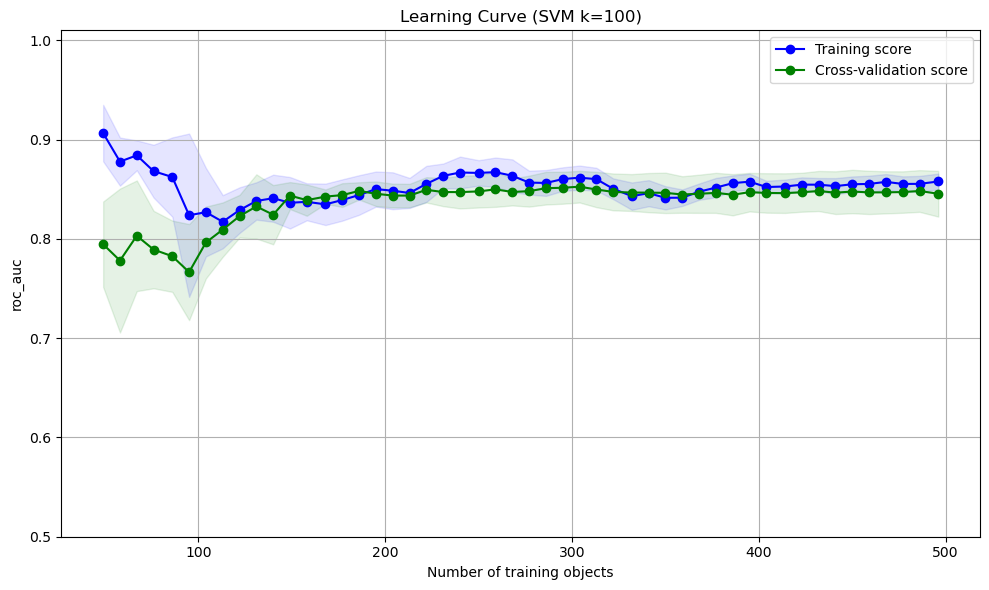

Number of Features Selected after RFECV: 10
Mean ROC AUC: 0.8543753600292721


In [70]:
# K = 100
# ====== PRE-FEATURE SELECTION ======
# Use SelectKBest with mutual_info_classif for feature selection
selector = SelectKBest(mutual_info_classif, k=100)
X_train_reduced = selector.fit_transform(X_train_transformed, y_train)
X_test_reduced = selector.transform(X_test_transformed)

# ====== FEATURE SELECTION ======
svm = SVC(kernel="linear", random_state=24)
rfecv = RFECV(estimator=svm, step=5, cv=cv, scoring='roc_auc')
rfecv.fit(X_train_reduced, y_train)
X_selected = rfecv.transform(X_train_reduced)
X_test_selected = rfecv.transform(X_test_reduced)

# ====== PIPELINE CHARACTERISTICS ======
svm = SVC(kernel="linear", random_state=24)

# ====== PIPELINE  ======
pipeline = Pipeline([
    ('svm', svm)
])

# ====== EVALUATION  ======
scores = cross_val_score(
    pipeline,
    X_selected,
    y_train,
    cv=cv,
    scoring='roc_auc',
    n_jobs=-1
)

pipeline.fit(X_selected, y_train)

plot_learning_curve(X_selected, y_train, classifier=pipeline, scoring='roc_auc', clf_type='SVM k=100')

selected_features = np.where(rfecv.support_)[0]
print(f"Number of Features Selected after RFECV: {len(selected_features)}")
print("Mean ROC AUC:", scores.mean())

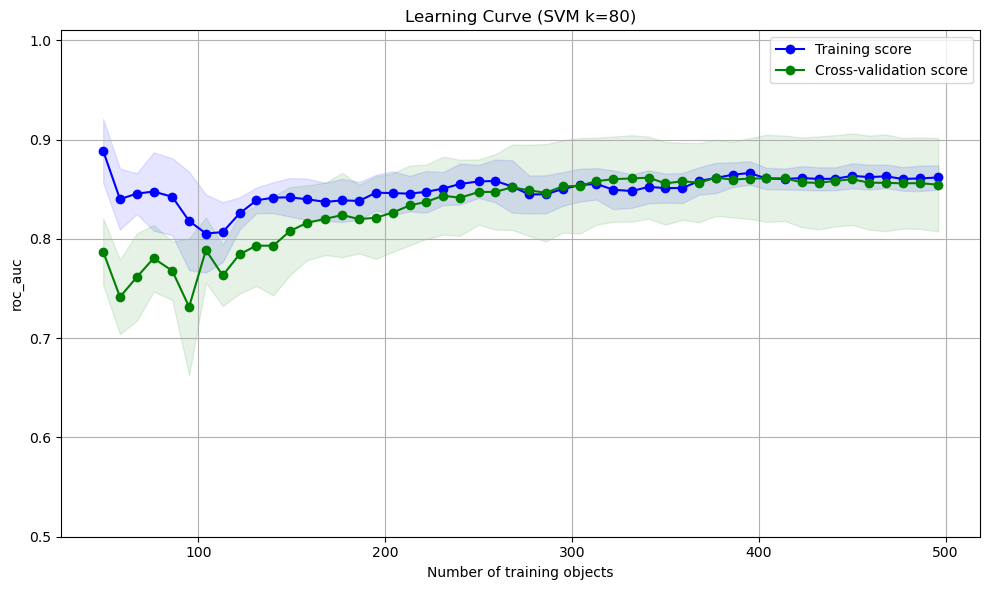

Number of Features Selected after RFECV: 10
Mean ROC AUC: 0.8516464308583098


In [71]:
# K = 80
# ====== PRE-FEATURE SELECTION ======
# Use SelectKBest with mutual_info_classif for feature selection
selector = SelectKBest(mutual_info_classif, k=80)
X_train_reduced = selector.fit_transform(X_train_transformed, y_train)
X_test_reduced = selector.transform(X_test_transformed)

# ====== FEATURE SELECTION ======
svm = SVC(kernel="linear", random_state=24)
rfecv = RFECV(estimator=svm, step=5, cv=cv, scoring='roc_auc')
rfecv.fit(X_train_reduced, y_train)
X_selected = rfecv.transform(X_train_reduced)
X_test_selected = rfecv.transform(X_test_reduced)

# ====== PIPELINE CHARACTERISTICS ======
svm = SVC(kernel="linear", random_state=24)

# ====== PIPELINE  ======
pipeline = Pipeline([
    ('svm', svm)
])

# ====== EVALUATION  ======
scores = cross_val_score(
    pipeline,
    X_selected,
    y_train,
    cv=cv,
    scoring='roc_auc',
    n_jobs=-1
)

pipeline.fit(X_selected, y_train)

plot_learning_curve(X_selected, y_train, classifier=pipeline, scoring='roc_auc', clf_type='SVM k=80')

selected_features = np.where(rfecv.support_)[0]
print(f"Number of Features Selected after RFECV: {len(selected_features)}")
print("Mean ROC AUC:", scores.mean())

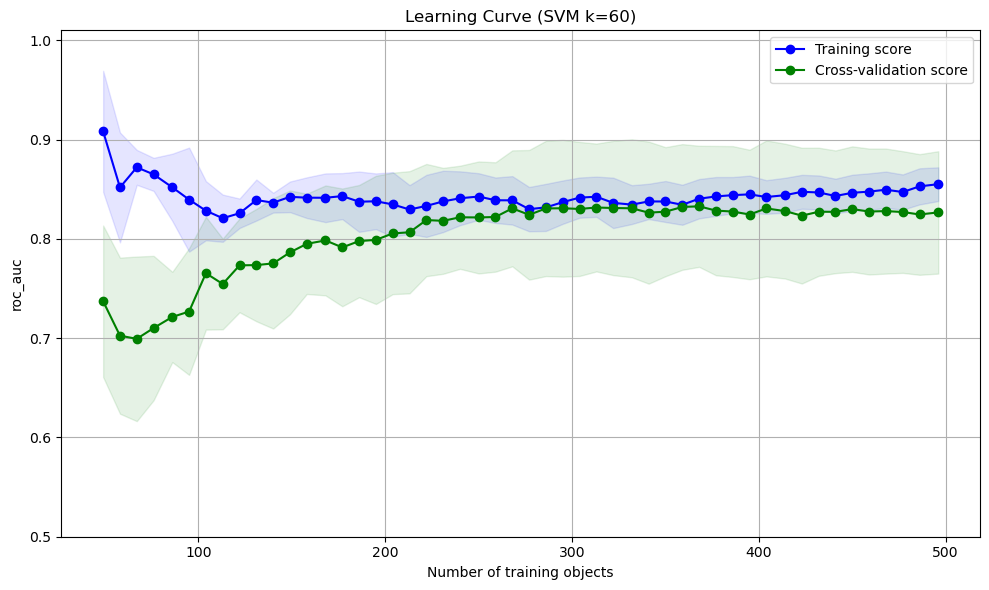

Number of Features Selected after RFECV: 15
Mean ROC AUC: 0.8356317107602088


In [72]:
# K = 60
# ====== PRE-FEATURE SELECTION ======
# Use SelectKBest with mutual_info_classif for feature selection
selector = SelectKBest(mutual_info_classif, k=60)
X_train_reduced = selector.fit_transform(X_train_transformed, y_train)
X_test_reduced = selector.transform(X_test_transformed)

# ====== FEATURE SELECTION ======
svm = SVC(kernel="linear", random_state=24)
rfecv = RFECV(estimator=svm, step=5, cv=cv, scoring='roc_auc')
rfecv.fit(X_train_reduced, y_train)
X_selected = rfecv.transform(X_train_reduced)
X_test_selected = rfecv.transform(X_test_reduced)

# ====== PIPELINE CHARACTERISTICS ======
svm = SVC(kernel="linear", random_state=24)

# ====== PIPELINE  ======
pipeline = Pipeline([
    ('svm', svm)
])

# ====== EVALUATION  ======
scores = cross_val_score(
    pipeline,
    X_selected,
    y_train,
    cv=cv,
    scoring='roc_auc',
    n_jobs=-1
)

pipeline.fit(X_selected, y_train)

plot_learning_curve(X_selected, y_train, classifier=pipeline, scoring='roc_auc', clf_type='SVM k=60')

selected_features = np.where(rfecv.support_)[0]
print(f"Number of Features Selected after RFECV: {len(selected_features)}")
print("Mean ROC AUC:", scores.mean())

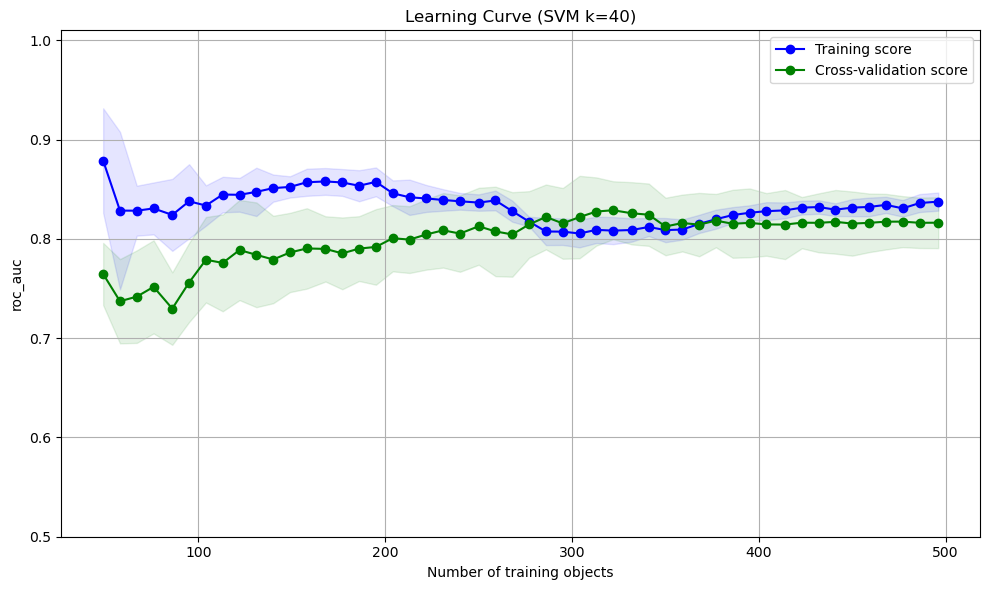

Number of Features Selected after RFECV: 10
Mean ROC AUC: 0.8221949856729982


In [73]:
# K = 40 
# ====== PRE-FEATURE SELECTION ======
# Use SelectKBest with mutual_info_classif for feature selection
selector = SelectKBest(mutual_info_classif, k=40)
X_train_reduced = selector.fit_transform(X_train_transformed, y_train)
X_test_reduced = selector.transform(X_test_transformed)

# ====== FEATURE SELECTION ======
svm = SVC(kernel="linear", random_state=24)
rfecv = RFECV(estimator=svm, step=5, cv=cv, scoring='roc_auc')
rfecv.fit(X_train_reduced, y_train)
X_selected = rfecv.transform(X_train_reduced)
X_test_selected = rfecv.transform(X_test_reduced)

# ====== PIPELINE CHARACTERISTICS ======
svm = SVC(kernel="linear", random_state=24)

# ====== PIPELINE  ======
pipeline = Pipeline([
    ('svm', svm)
])

# ====== EVALUATION  ======
scores = cross_val_score(
    pipeline,
    X_selected,
    y_train,
    cv=cv,
    scoring='roc_auc',
    n_jobs=-1
)

pipeline.fit(X_selected, y_train)

plot_learning_curve(X_selected, y_train, classifier=pipeline, scoring='roc_auc', clf_type='SVM k=40')

selected_features = np.where(rfecv.support_)[0]
print(f"Number of Features Selected after RFECV: {len(selected_features)}")
print("Mean ROC AUC:", scores.mean())

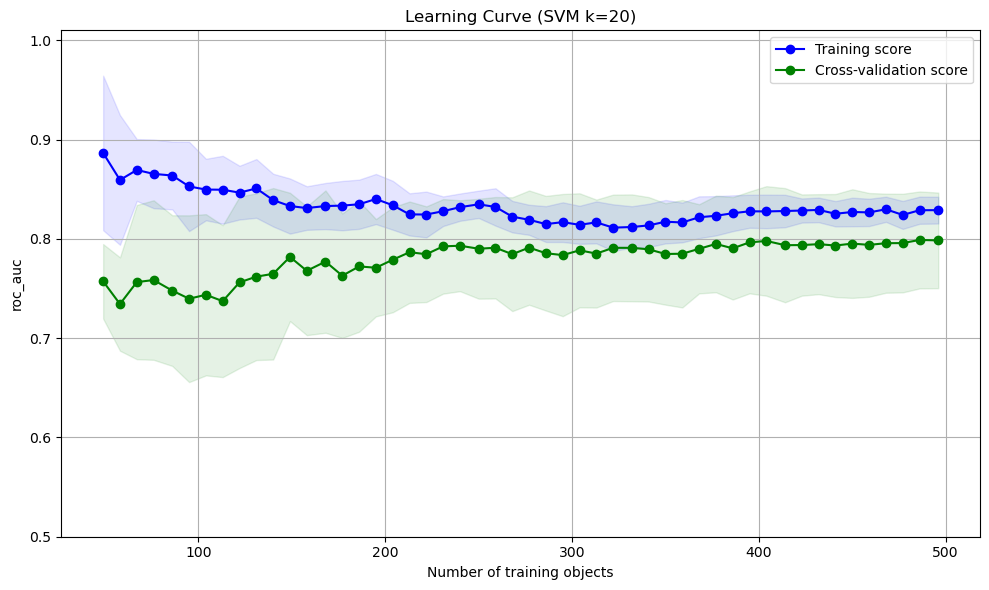

Number of Features Selected after RFECV: 15
Mean ROC AUC: 0.7976712132337488


In [74]:
# K = 20
# ====== PRE-FEATURE SELECTION ======
# Use SelectKBest with mutual_info_classif for fe5ature selection
selector = SelectKBest(mutual_info_classif, k=20)
X_train_reduced = selector.fit_transform(X_train_transformed, y_train)
X_test_reduced = selector.transform(X_test_transformed)

# ====== FEATURE SELECTION ======
svm = SVC(kernel="linear", random_state=24)
rfecv = RFECV(estimator=svm, step=5, cv=cv, scoring='roc_auc')
rfecv.fit(X_train_reduced, y_train)
X_selected = rfecv.transform(X_train_reduced)
X_test_selected = rfecv.transform(X_test_reduced)

# ====== PIPELINE CHARACTERISTICS ======
svm = SVC(kernel="linear", random_state=24)

# ====== PIPELINE  ======
pipeline = Pipeline([
    ('svm', svm)
])

# ====== EVALUATION  ======
scores = cross_val_score(
    pipeline,
    X_selected,
    y_train,
    cv=cv,
    scoring='roc_auc',
    n_jobs=-1
)

pipeline.fit(X_selected, y_train)

plot_learning_curve(X_selected, y_train, classifier=pipeline, scoring='roc_auc', clf_type='SVM k=20')

selected_features = np.where(rfecv.support_)[0]
print(f"Number of Features Selected after RFECV: {len(selected_features)}")
print("Mean ROC AUC:", scores.mean())

Since K=20 gave the best learning curve, also a learning curve for K=25 and K=15 are made. 

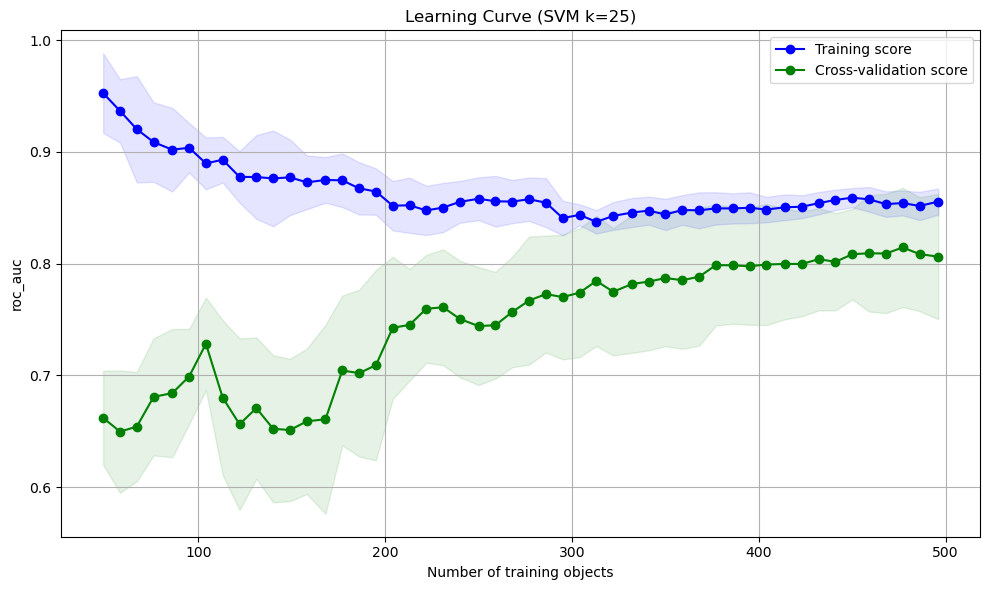

Number of Features Selected after RFECV: 25
Mean ROC AUC: 0.8062403425624444


In [14]:
#K=25
# ====== PRE-FEATURE SELECTION ======
# Use SelectKBest with mutual_info_classif for feature selection
selector = SelectKBest(mutual_info_classif, k=25)
X_train_reduced = selector.fit_transform(X_train_transformed, y_train)
X_test_reduced = selector.transform(X_test_transformed)

# ====== FEATURE SELECTION ======
svm = SVC(kernel="linear", random_state=42)
rfecv = RFECV(estimator=svm, step=5, cv=cv, scoring='roc_auc')
rfecv.fit(X_train_reduced, y_train)
X_selected = rfecv.transform(X_train_reduced)
X_test_selected = rfecv.transform(X_test_reduced)

# ====== PIPELINE CHARACTERISTICS ======
svm = SVC(kernel="linear", random_state=42)

# ====== PIPELINE  ======
pipeline = Pipeline([
    ('svm', svm)
])

# ====== EVALUATION  ======
scores = cross_val_score(
    pipeline,
    X_selected,
    y_train,
    cv=cv,
    scoring='roc_auc',
    n_jobs=-1
)

pipeline.fit(X_selected, y_train)

plot_learning_curve(X_selected, y_train, classifier=pipeline, scoring='roc_auc', clf_type='SVM k=25')

selected_features = np.where(rfecv.support_)[0]
print(f"Number of Features Selected after RFECV: {len(selected_features)}")
print("Mean ROC AUC:", scores.mean())

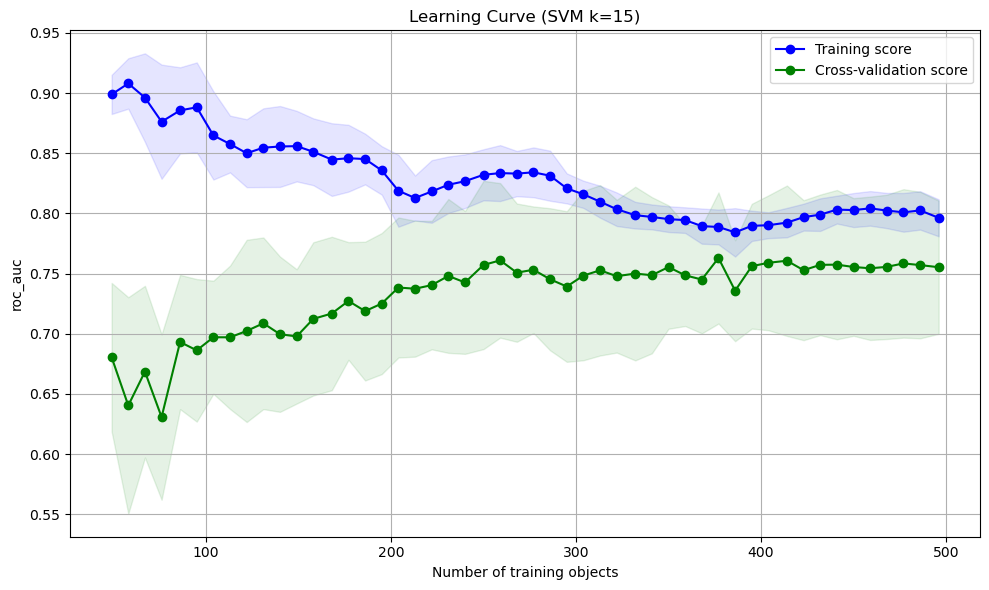

Number of Features Selected after RFECV: 15
Mean ROC AUC: 0.7553187912411213


In [15]:
# K = 15
# ====== PRE-FEATURE SELECTION ======
# Use SelectKBest with mutual_info_classif for feature selection
selector = SelectKBest(mutual_info_classif, k=15)
X_train_reduced = selector.fit_transform(X_train_transformed, y_train)
X_test_reduced = selector.transform(X_test_transformed)

# ====== FEATURE SELECTION ======
svm = SVC(kernel="linear", random_state=42)
rfecv = RFECV(estimator=svm, step=5, cv=cv, scoring='roc_auc')
rfecv.fit(X_train_reduced, y_train)
X_selected = rfecv.transform(X_train_reduced)
X_test_selected = rfecv.transform(X_test_reduced)

# ====== PIPELINE CHARACTERISTICS ======
svm = SVC(kernel="linear", random_state=42)

# ====== PIPELINE  ======
pipeline = Pipeline([
    ('svm', svm)
])

# ====== EVALUATION  ======
scores = cross_val_score(
    pipeline,
    X_selected,
    y_train,
    cv=cv,
    scoring='roc_auc',
    n_jobs=-1
)

pipeline.fit(X_selected, y_train)

plot_learning_curve(X_selected, y_train, classifier=pipeline, scoring='roc_auc', clf_type='SVM k=15')

selected_features = np.where(rfecv.support_)[0]
print(f"Number of Features Selected after RFECV: {len(selected_features)}")
print("Mean ROC AUC:", scores.mean())

Linear kernel tuned

In [5]:
# once specify the characteristics of the SVM for SVC feature selection
svm_feature = SVC(kernel="linear", random_state=42, class_weight='balanced')

Best estimator: Pipeline(steps=[('transformer', PowerTransformer()),
                ('select_k_best',
                 SelectKBest(k=25,
                             score_func=<function mutual_info_classif at 0x000001F75421B1A0>)),
                ('rfecv',
                 RFECV(cv=StratifiedKFold(n_splits=5, random_state=42, shuffle=True),
                       estimator=SVC(class_weight='balanced', kernel='linear',
                                     random_state=42),
                       scoring='roc_auc', step=5)),
                ('classifier',
                 SVC(C=10, class_weight='balanced', kernel='linear',
                     random_state=42, tol=1e-06))])
Best Score: 0.7669115483792811
Best parameters: {'classifier__tol': 1e-06, 'classifier__max_iter': -1, 'classifier__C': 10}
Mean ROC AUC: 0.7276182935663231


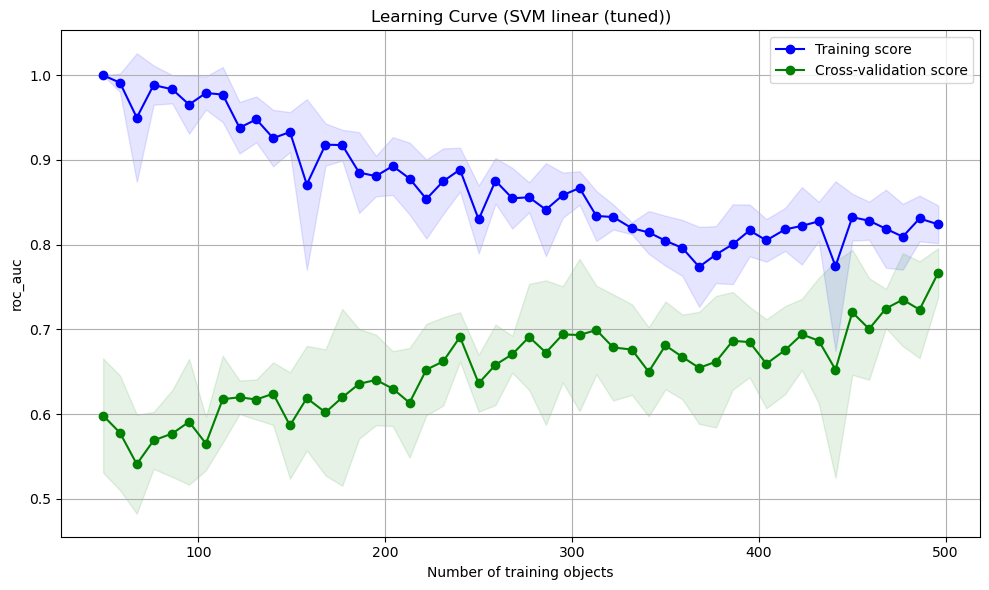

In [9]:
# tuned linear kernel
# ====== PIPELINE  ======
pipeline = Pipeline([
    ('transformer', PowerTransformer(method='yeo-johnson')),
    ('select_k_best', SelectKBest(mutual_info_classif, k=25)),
    ('rfecv', RFECV(estimator=svm_feature, step=5, cv=cv, scoring='roc_auc')),
    ('classifier', SVC(kernel='linear', random_state=42, class_weight='balanced'))
])

parameters = {
    'classifier__C':            [0.001, 0.01, 0.1, 1, 10, 100],
    'classifier__tol':          [1e-4, 1e-5, 1e-6],             
    'classifier__max_iter':     [1000, 10000, -1]    
}

# ====== EVALUATION  ======
random_search = RandomizedSearchCV(
    pipeline,
    param_distributions=parameters,
    n_iter=20,
    n_jobs=-1,
    cv=cv,
    scoring='roc_auc'  ,
    random_state=42
) 

random_search.fit(X_train, y_train)

print("Best estimator:", random_search.best_estimator_ )
print("Best Score:", random_search.best_score_)
print("Best parameters:", random_search.best_params_)
print("Mean ROC AUC:", random_search.cv_results_['mean_test_score'].mean())

plot_learning_curve(X_train, y_train, classifier=random_search.best_estimator_, scoring='roc_auc', clf_type='SVM linear (tuned)')


Since the data did not seem to be linear seperable a polynomial and RBF kernel are also trained

Fitting 5 folds for each of 20 candidates, totalling 100 fits
Best estimator:
 Pipeline(steps=[('transformer', PowerTransformer()),
                ('select_k_best',
                 SelectKBest(k=25,
                             score_func=<function mutual_info_classif at 0x00000285D014B240>)),
                ('rfecv',
                 RFECV(cv=StratifiedKFold(n_splits=5, random_state=42, shuffle=True),
                       estimator=SVC(class_weight='balanced', kernel='linear',
                                     random_state=42),
                       scoring='roc_auc', step=5)),
                ('classifier',
                 SVC(C=0.001, class_weight='balanced', gamma=1e-05,
                     kernel='poly', max_iter=1000, random_state=42,
                     tol=1e-05))])
Best Score: 0.7467384129291611
Best parameters: {'classifier__tol': 1e-05, 'classifier__max_iter': 1000, 'classifier__gamma': 1e-05, 'classifier__C': 0.001}
Mean ROC AUC: 0.7349738553850489


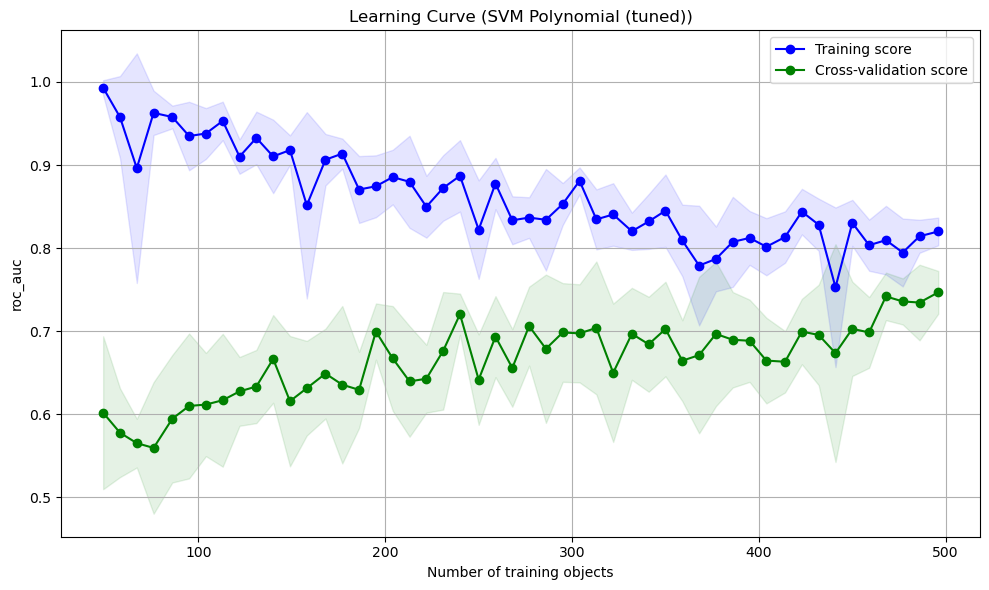

In [6]:
# tuned polynomial kernel
# ====== PIPELINE  ======
pipeline = Pipeline([
    ('transformer', PowerTransformer(method='yeo-johnson')),
    ('select_k_best', SelectKBest(mutual_info_classif, k=25)),
    ('rfecv', RFECV(estimator=svm_feature, step=5, cv=cv, scoring='roc_auc')),
    ('classifier', SVC(kernel='poly', random_state=42, class_weight='balanced'))
])

param_grid = {
    'classifier__C': [0.001, 0.01, 0.1],
    'classifier__gamma': [1e-6, 1e-5, 1e-4],
    'classifier__tol': [1e-4, 1e-5, 1e-6],
    'classifier__max_iter': [1000, 10000, -1]
}

# ====== 3. RANDOMIZED SEARCH MET CROSS-VALIDATIE ======
random_search = RandomizedSearchCV(
    estimator=pipeline,
    param_distributions=param_grid,
    n_iter=20,
    scoring='roc_auc',
    cv=cv,
    n_jobs=-1,
    verbose=1,
    refit=True,
    random_state=42
)

# ====== 4. TRAINING ======
random_search.fit(X_train, y_train)

# ====== 5. RESULTATEN ======
print("Best estimator:\n", random_search.best_estimator_)
print("Best Score:", random_search.best_score_)
print("Best parameters:", random_search.best_params_)
print("Mean ROC AUC:", random_search.cv_results_['mean_test_score'].mean())

# ====== 6. LEARNING CURVE PLOT ======
plot_learning_curve(
    X_train,
    y_train,
    classifier=random_search.best_estimator_,
    scoring='roc_auc',
    clf_type='SVM Polynomial (tuned)'
)

Fitting 5 folds for each of 20 candidates, totalling 100 fits
Best estimator:
 Pipeline(steps=[('transformer', PowerTransformer()),
                ('select_k_best',
                 SelectKBest(k=25,
                             score_func=<function mutual_info_classif at 0x00000285D014B240>)),
                ('rfecv',
                 RFECV(cv=StratifiedKFold(n_splits=5, random_state=42, shuffle=True),
                       estimator=SVC(class_weight='balanced', kernel='linear',
                                     random_state=42),
                       scoring='roc_auc', step=5)),
                ('classifier',
                 SVC(C=5, class_weight='balanced', gamma=0.0085,
                     random_state=42, tol=0.0005))])
Best Score: 0.7551982664204251
Best parameters: {'classifier__tol': 0.0005, 'classifier__max_iter': -1, 'classifier__gamma': 0.0085, 'classifier__C': 5}
Mean ROC AUC: 0.7543386957607403


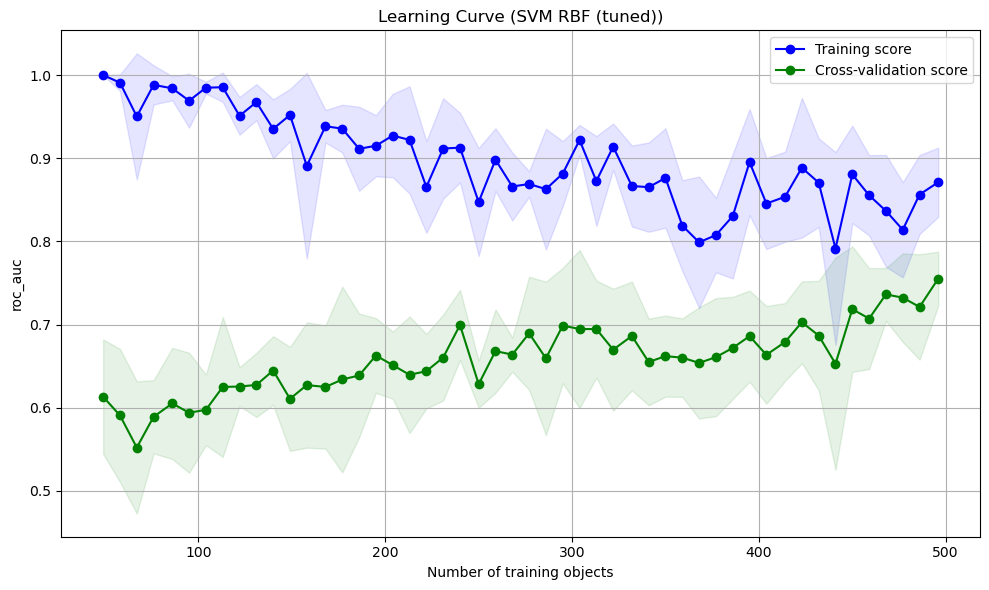

In [7]:
# tuned RBF kernel
# ====== PIPELINE  ======
pipeline = Pipeline([
    ('transformer', PowerTransformer(method='yeo-johnson')),
    ('select_k_best', SelectKBest(mutual_info_classif, k=25)),
    ('rfecv', RFECV(estimator=svm_feature, step=5, cv=cv, scoring='roc_auc')),
    ('classifier', SVC(kernel='rbf', random_state=42, class_weight='balanced'))
])

param_grid = {
    'classifier__C': [4, 4.5, 5],
    'classifier__gamma': [0.0085, 0.009, 0.0095],
    'classifier__tol': [3e-4, 5e-4, 7e-4],
    'classifier__max_iter': [80000, 10000, -1]
}

# ====== 3. RANDOMIZED SEARCH MET CROSS-VALIDATIE ======
random_search = RandomizedSearchCV(
    estimator=pipeline,
    param_distributions=param_grid,
    n_iter=20,
    scoring='roc_auc',
    cv=cv,
    n_jobs=-1,
    verbose=1,
    refit=True,
    random_state=42
)

# ====== 4. TRAINING ======
random_search.fit(X_train, y_train)

# ====== 5. RESULTATEN ======
print("Best estimator:\n", random_search.best_estimator_)
print("Best Score:", random_search.best_score_)
print("Best parameters:", random_search.best_params_)
print("Mean ROC AUC:", random_search.cv_results_['mean_test_score'].mean())

# ====== 6. LEARNING CURVE PLOT ======
plot_learning_curve(
    X_train,
    y_train,
    classifier=random_search.best_estimator_,
    scoring='roc_auc',
    clf_type='SVM RBF (tuned)'
)

The linear model had the best performance, therefore this model was chosen for final evaluation

Best Parameters: {'classifier__tol': 1e-06, 'classifier__max_iter': -1, 'classifier__C': 0.01}
Best Score: 0.7322695834379785
Accuracy:  0.735
Precision: 0.347
Recall:    0.586
F1 Score:  0.436
AUC Score: 0.700
Best Parameters: {'classifier__tol': 0.0001, 'classifier__max_iter': 10000, 'classifier__C': 0.001}
Best Score: 0.6942727030979923
Accuracy:  0.801
Precision: 0.459
Recall:    0.567
F1 Score:  0.507
AUC Score: 0.758
Best Parameters: {'classifier__tol': 1e-06, 'classifier__max_iter': 10000, 'classifier__C': 0.001}
Best Score: 0.7853842574125781
Accuracy:  0.739
Precision: 0.354
Recall:    0.586
F1 Score:  0.442
AUC Score: 0.728
Best Parameters: {'classifier__tol': 1e-06, 'classifier__max_iter': 10000, 'classifier__C': 0.001}
Best Score: 0.7625980587687808
Accuracy:  0.794
Precision: 0.432
Recall:    0.552
F1 Score:  0.485
AUC Score: 0.764
Best Parameters: {'classifier__tol': 1e-06, 'classifier__max_iter': 10000, 'classifier__C': 0.001}
Best Score: 0.7821898683685681
Accuracy:  0.

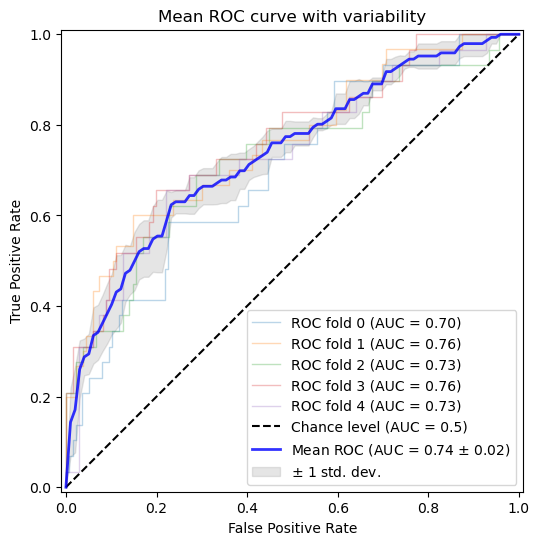

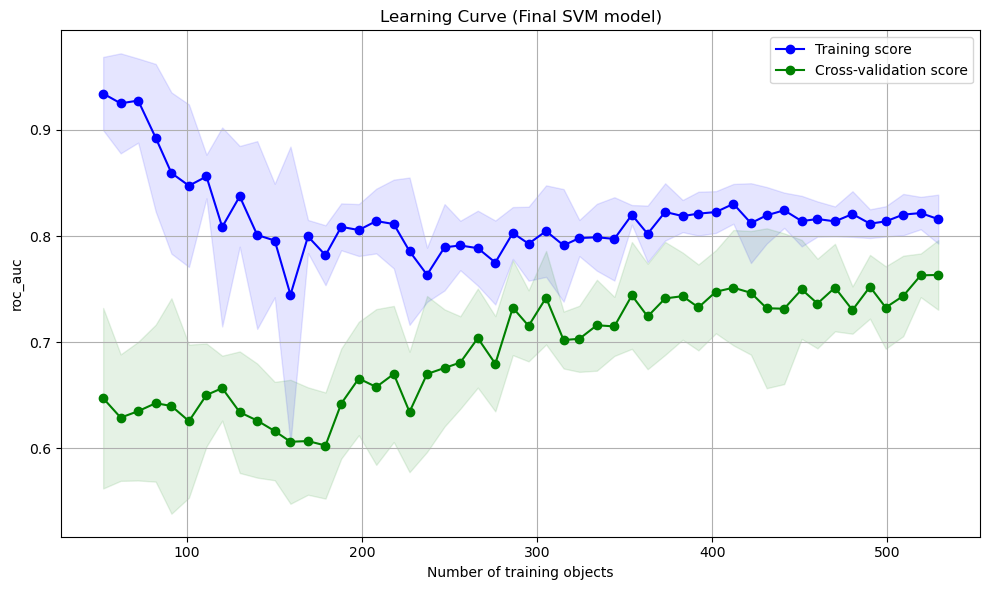

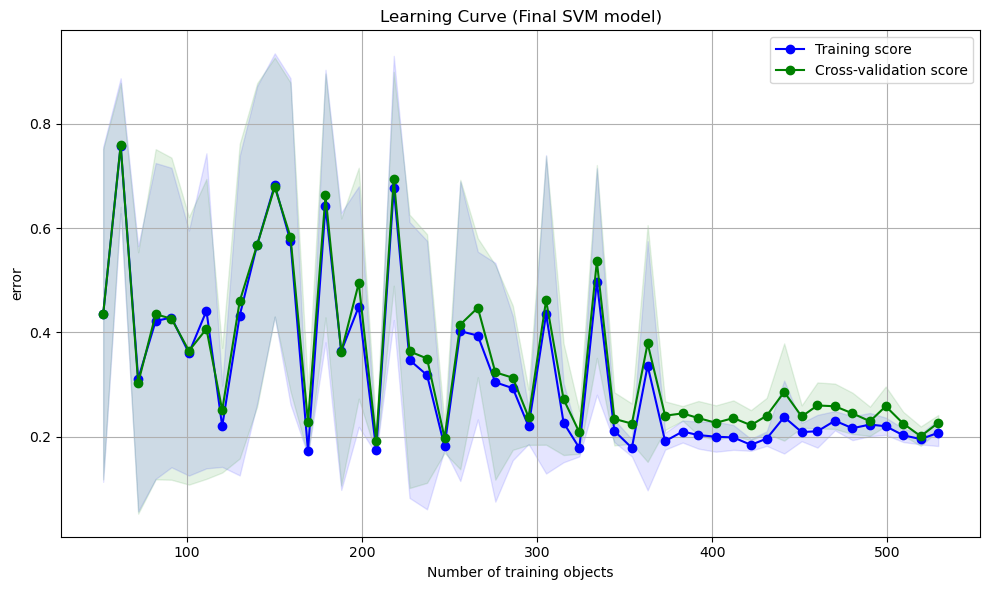

In [7]:
# ROC AUC curve with outside cross validation
def optimize_svm(X_train, y_train):
    # ====== PIPELINE  ======
    pipeline = Pipeline([
        ('transformer', PowerTransformer(method='yeo-johnson')),
        ('select_k_best', SelectKBest(mutual_info_classif, k=25)),
        ('rfecv', RFECV(estimator=svm_feature, step=5, cv=cv, scoring='roc_auc')),
        ('classifier', SVC(kernel='linear', random_state=42, class_weight='balanced', probability=True))
    ])

    parameters = {
        'classifier__C':            [0.001, 0.01, 0.1, 1, 10, 100],
        'classifier__tol':          [1e-4, 1e-5, 1e-6],             
        'classifier__max_iter':     [1000, 10000, -1]    
    }

    # ====== EVALUATION  ======
    random_search = RandomizedSearchCV(
        pipeline,
        param_distributions=parameters,
        n_iter=20,
        n_jobs=-1,
        cv=StratifiedKFold(n_splits=5, shuffle=True, random_state=42),
        scoring='roc_auc',
        random_state=42  
    ) 

    random_search.fit(X_train, y_train)

    print("Best Parameters:", random_search.best_params_)
    print("Best Score:", random_search.best_score_)
    return random_search.best_estimator_

# Perform hyperparameter optimization and plot the ROC curves and learning curves
X = data.iloc[:,:-1]
y = data.iloc[:,-1]

X_train_final, y_train_final, best_classifier = plot_roc_cv(X, y, optimize_svm, n_splits=5)
plot_learning_curve(X_train_final, y_train_final, best_classifier, scoring='roc_auc', clf_type='Final SVM model')
plot_learning_curve(X_train_final, y_train_final, best_classifier, scoring='error', clf_type='Final SVM model')

### Tuning steps for SVM

Select correct features

In [9]:
# ====== PRE-FEATURE SELECTION ======
# Apply Power Transformation to handle skewed data
power_transformer = PowerTransformer(method='yeo-johnson')
X_train_transformed = power_transformer.fit_transform(X_train)
X_test_transformed = power_transformer.transform(X_test)

# Use SelectKBest with mutual_info_classif for feature selection
selector = SelectKBest(mutual_info_classif, k=25)
X_train_reduced = selector.fit_transform(X_train_transformed, y_train)
X_test_reduced = selector.transform(X_test_transformed)

# ====== FEATURE SELECTION ======
rfecv = RFECV(estimator=svm_feature, step=5, cv=cv, scoring='roc_auc')
rfecv.fit(X_train_reduced, y_train)
X_selected = rfecv.transform(X_train_reduced)
X_test_selected = rfecv.transform(X_test_reduced)

Linear kernel

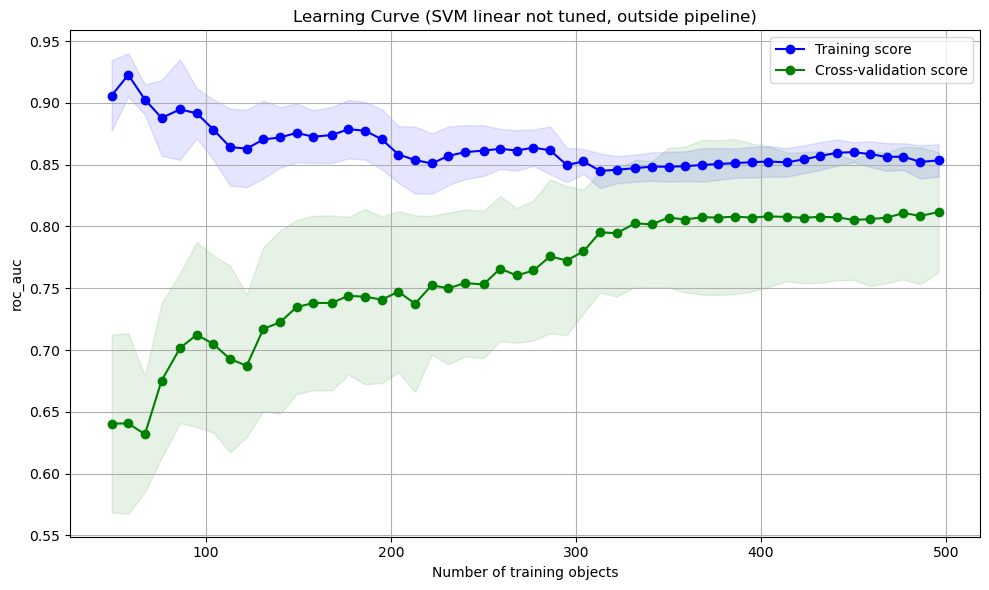

Mean ROC AUC: 0.8116650720305774


In [10]:
# Not tuned linear kernel outside the pipeline
# ====== PIPELINE  ======
pipeline = Pipeline([
    ('classifier', SVC(kernel='linear', random_state=42, class_weight='balanced'))
])


# ====== EVALUATION  ======
scores = cross_val_score(
    pipeline,
    X_selected,
    y_train,
    cv=cv,
    scoring='roc_auc',
    n_jobs=-1
)

pipeline.fit(X_selected, y_train)

plot_learning_curve(X_selected, y_train, classifier=pipeline, scoring='roc_auc', clf_type='SVM linear not tuned, outside pipeline')
print("Mean ROC AUC:", scores.mean())

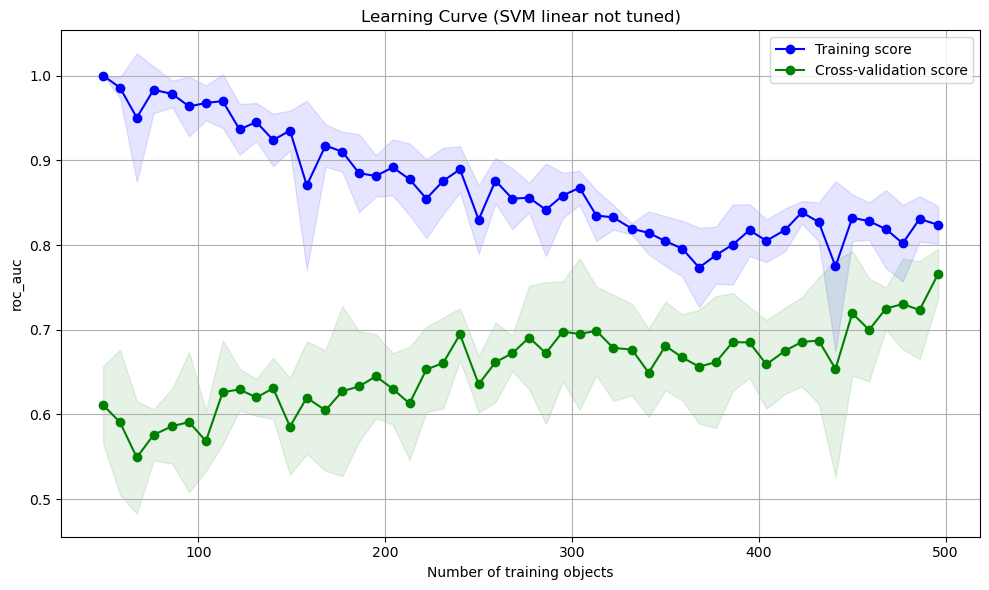

Mean ROC AUC: 0.7662085487328205


In [22]:
# Not tuned linear kernel inside the pipeline
# ====== PIPELINE  ======
pipeline = Pipeline([
    ('transformer', PowerTransformer(method='yeo-johnson')),
    ('select_k_best', SelectKBest(mutual_info_classif, k=25)),
    ('rfecv', RFECV(estimator=svm_feature, step=5, cv=cv, scoring='roc_auc')),
    ('classifier', SVC(kernel='linear', random_state=42, class_weight='balanced'))
])


# ====== EVALUATION  ======
scores = cross_val_score(
    pipeline,
    X_train,
    y_train,
    cv=cv,
    scoring='roc_auc',
    n_jobs=-1
)

pipeline.fit(X_train, y_train)

plot_learning_curve(X_train, y_train, classifier=pipeline, scoring='roc_auc', clf_type='SVM linear not tuned')
print("Mean ROC AUC:", scores.mean())

Fitting 5 folds for each of 20 candidates, totalling 100 fits
Best estimator:
 Pipeline(steps=[('classifier',
                 SVC(C=0.1, class_weight='balanced', kernel='linear',
                     random_state=42, tol=1e-06))])
Best ROC AUC-score: 0.8132793629367014
Best hyperparameters: {'classifier__tol': 1e-06, 'classifier__max_iter': -1, 'classifier__C': 0.1}
Mean ROC AUC: 0.7667878342864065


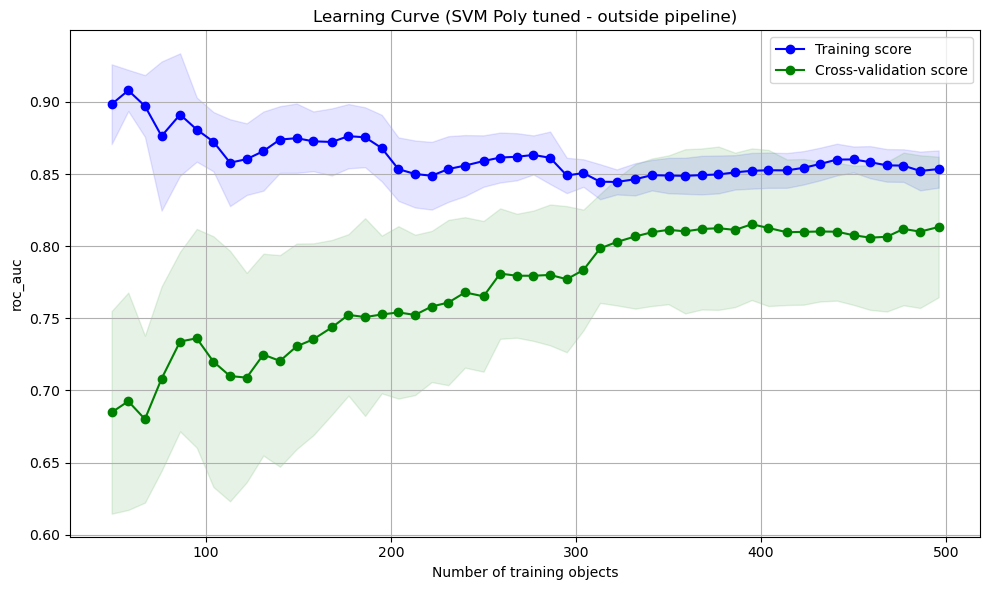

In [12]:
# Tuned linear kernel outside the pipeline
# ====== PIPELINE CHARACTERISTICS ======
svm = SVC(
    kernel="linear",  
    random_state=42,
    class_weight='balanced'
)

# ====== PIPELINE ======
pipeline = Pipeline([
    ('classifier', svm)
])

# ====== HYPERPARAMETER ======
parameters = {
    'classifier__C':            [0.001, 0.01, 0.1, 1, 10, 100],
    'classifier__tol':          [1e-4, 1e-5, 1e-6],             
    'classifier__max_iter':     [1000, 10000, -1]    
}


# ====== 3. RANDOMIZED SEARCH MET CROSS-VALIDATIE ======
random_search = RandomizedSearchCV(
    estimator=pipeline,
    param_distributions=parameters,
    n_iter=20,
    scoring='roc_auc',
    cv=cv,
    n_jobs=-1,
    verbose=1,
    refit=True
)

# ====== 4. TRAINING ======
random_search.fit(X_selected, y_train)

# ====== 5. RESULTATEN ======
print("Best estimator:\n", random_search.best_estimator_)
print("Best ROC AUC-score:", random_search.best_score_)
print("Best hyperparameters:", random_search.best_params_)
print("Mean ROC AUC:", random_search.cv_results_['mean_test_score'].mean())

# ====== 6. LEARNING CURVE PLOT ======
plot_learning_curve(
    X_selected,
    y_train,
    classifier=random_search.best_estimator_,
    scoring='roc_auc',
    clf_type='SVM Poly tuned - outside pipeline'
)

Polynomial kernel



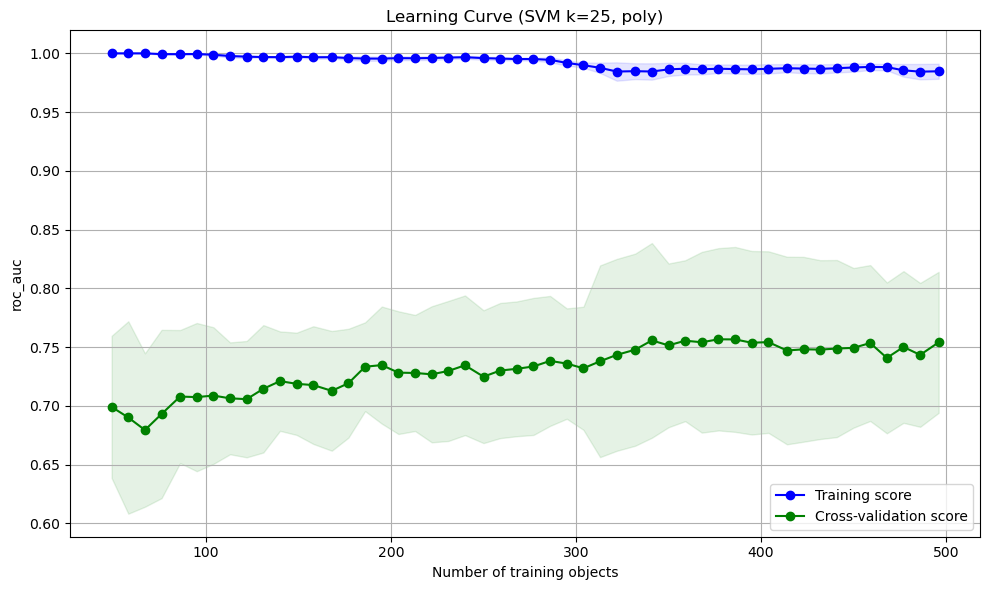

Mean ROC AUC: 0.7540806613907698


In [13]:
# not tuned polynomial outside the pipeline
# ====== PIPELINE CHARACTERISTICS ======
svm = SVC(kernel="poly", random_state=42, class_weight='balanced')

# ====== PIPELINE  ======
pipeline = Pipeline([
    ('svm', svm)
])

# ====== EVALUATION  ======
scores = cross_val_score(
    pipeline,
    X_selected,
    y_train,
    cv=cv,
    scoring='roc_auc',
    n_jobs=-1
)

pipeline.fit(X_selected, y_train)

plot_learning_curve(X_selected, y_train, classifier=pipeline, scoring='roc_auc', clf_type='SVM k=25, poly')
print("Mean ROC AUC:", scores.mean())

Fitting 5 folds for each of 20 candidates, totalling 100 fits
Best estimator:
 Pipeline(steps=[('classifier',
                 SVC(C=0.1, class_weight='balanced', gamma=1e-06, kernel='poly',
                     max_iter=1000, random_state=42, tol=1e-05))])
Best ROC AUC-score: 0.7967562135180638
Best hyperparameters: {'classifier__tol': 1e-05, 'classifier__max_iter': 1000, 'classifier__gamma': 1e-06, 'classifier__C': 0.1}
Mean ROC AUC: 0.792782726506313


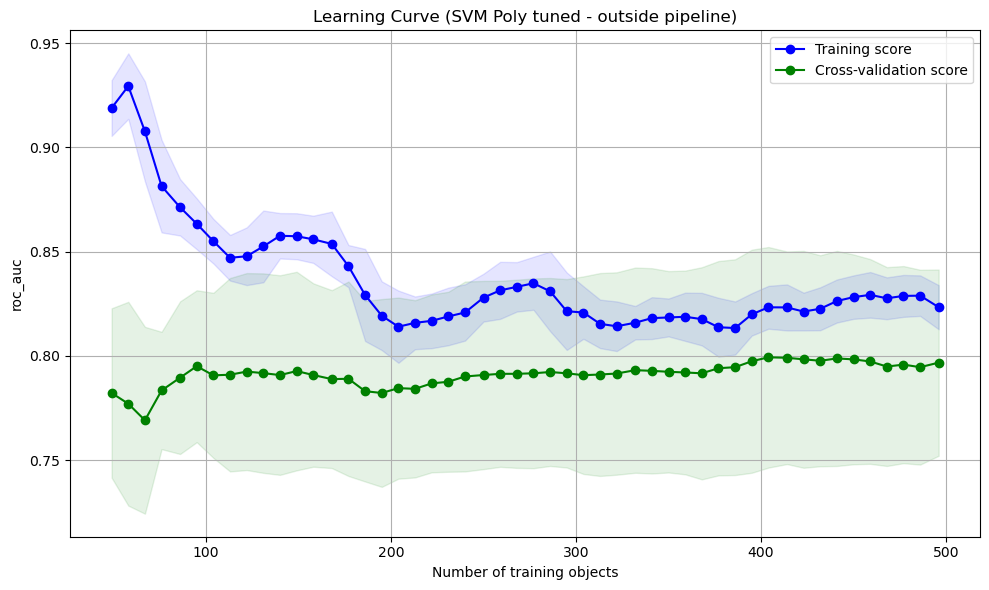

In [14]:
# tuned poly outside pipeline
# ====== PIPELINE CHARACTERISTICS ======
svm = SVC(
    kernel="poly",  
    random_state=42,
    class_weight='balanced'
)

# ====== PIPELINE ======
pipeline = Pipeline([
    ('classifier', svm)
])

# ====== HYPERPARAMETER ======
param_grid = {
    'classifier__C': [0.001, 0.01, 0.1],
    'classifier__gamma': [1e-6, 1e-5, 1e-4],
    'classifier__tol': [1e-4, 1e-5, 1e-6],
    'classifier__max_iter': [1000, 10000, -1]
}


# ====== 3. RANDOMIZED SEARCH MET CROSS-VALIDATIE ======
random_search = RandomizedSearchCV(
    estimator=pipeline,
    param_distributions=param_grid,
    n_iter=20,
    scoring='roc_auc',
    cv=cv,
    n_jobs=-1,
    verbose=1,
    refit=True
)

# ====== 4. TRAINING ======
random_search.fit(X_selected, y_train)

# ====== 5. RESULTATEN ======
print("Best estimator:\n", random_search.best_estimator_)
print("Best ROC AUC-score:", random_search.best_score_)
print("Best hyperparameters:", random_search.best_params_)
print("Mean ROC AUC:", random_search.cv_results_['mean_test_score'].mean())


# ====== 6. LEARNING CURVE PLOT ======
plot_learning_curve(
    X_selected,
    y_train,
    classifier=random_search.best_estimator_,
    scoring='roc_auc',
    clf_type='SVM Poly tuned - outside pipeline'
)

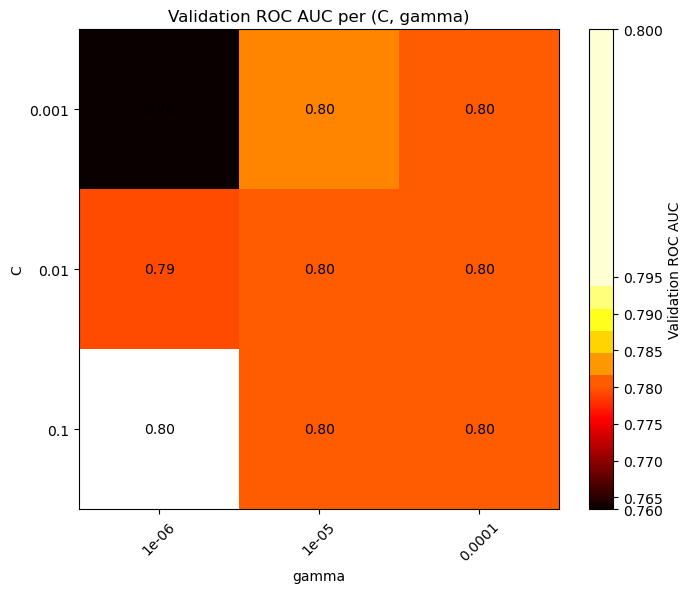

In [16]:
# code for hyperparameter tuning of polynomial
# ===== MidpointNormalize class =====
class MidpointNormalize(Normalize):
    def __init__(self, vmin=None, vmax=None, midpoint=None, clip=False):
        self.midpoint = midpoint
        super().__init__(vmin, vmax, clip)

    def __call__(self, value, clip=None):
        return np.ma.masked_array(np.interp(value, [self.vmin, self.midpoint, self.vmax], [0, 0.5, 1]))

# ===== Extract C and gamma ranges from param_grid =====
C_range = param_grid['classifier__C']
gamma_range = param_grid['classifier__gamma']

scores = np.full((len(C_range), len(gamma_range)), np.nan)  # initialize with NaN

for idx, result in enumerate(random_search.cv_results_['params']):
    c_val = result['classifier__C']
    gamma_val = result['classifier__gamma']
    if c_val in C_range and gamma_val in gamma_range:
        c_idx = C_range.index(c_val)
        gamma_idx = gamma_range.index(gamma_val)
        scores[c_idx, gamma_idx] = random_search.cv_results_['mean_test_score'][idx]

# ===== Plot heatmap =====
plt.figure(figsize=(8, 6))
plt.subplots_adjust(left=0.2, right=0.95, bottom=0.15, top=0.95)

plt.imshow(
    scores,
    interpolation="nearest",
    cmap=plt.cm.hot,
    norm=MidpointNormalize(
        vmin=np.nanmin(scores),
        midpoint=np.nanmedian(scores),
        vmax=np.nanmax(scores)
    )
)

plt.xlabel("gamma")
plt.ylabel("C")
plt.colorbar(label='Validation ROC AUC')
plt.xticks(np.arange(len(gamma_range)), gamma_range, rotation=45)
plt.yticks(np.arange(len(C_range)), C_range)
plt.title("Validation ROC AUC per (C, gamma)")

# ===== ROC =====
for i in range(len(C_range)):
    for j in range(len(gamma_range)):
        if not np.isnan(scores[i, j]):
            plt.text(j, i, f"{scores[i, j]:.2f}", ha='center', va='center', color='black')

plt.show()

RBF kernel

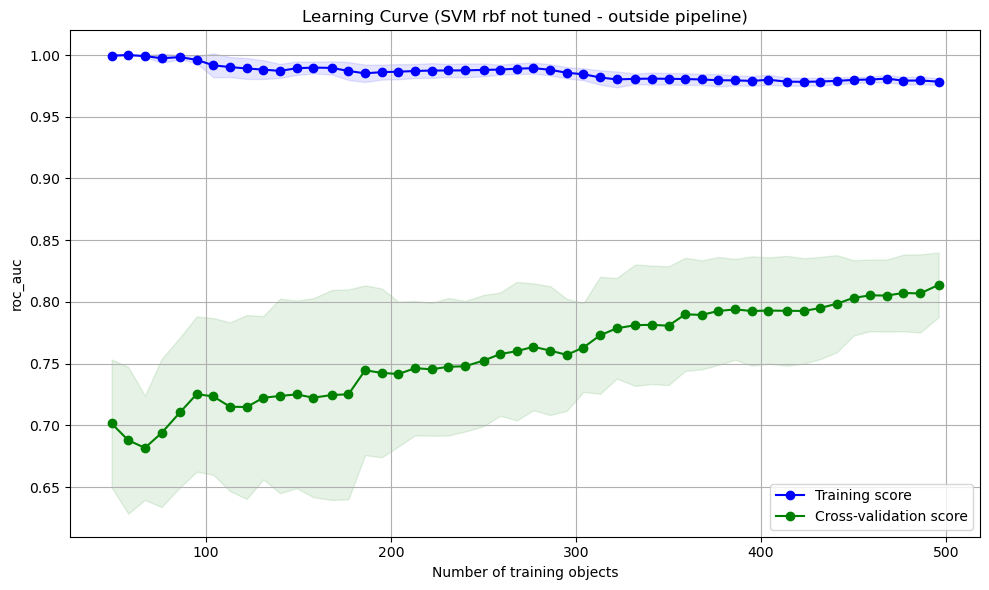

Mean ROC AUC: 0.8137927368652669


In [17]:
# not tuned RBF kernel outside the pipeline
# ====== PIPELINE CHARACTERISTICS ======
svm = SVC(kernel="rbf", random_state=42, class_weight='balanced')

# ====== PIPELINE  ======
pipeline = Pipeline([
    ('svm', svm)
])

# ====== EVALUATION  ======
scores = cross_val_score(
    pipeline,
    X_selected,
    y_train,
    cv=cv,
    scoring='roc_auc',
    n_jobs=-1
)

pipeline.fit(X_selected, y_train)

plot_learning_curve(X_selected, y_train, classifier=pipeline, scoring='roc_auc', clf_type='SVM rbf not tuned - outside pipeline')
print("Mean ROC AUC:", scores.mean())

Fitting 5 folds for each of 20 candidates, totalling 100 fits
Best estimator:
 Pipeline(steps=[('classifier',
                 SVC(C=0.1, class_weight='balanced', gamma=0.1, random_state=42,
                     tol=0.0001))])
Best ROC AUC-score: 0.8291615675396372
Best hyperparameters: {'classifier__tol': 0.0001, 'classifier__max_iter': -1, 'classifier__gamma': 0.1, 'classifier__C': 0.1}
Mean ROC AUC: 0.7907185875232706


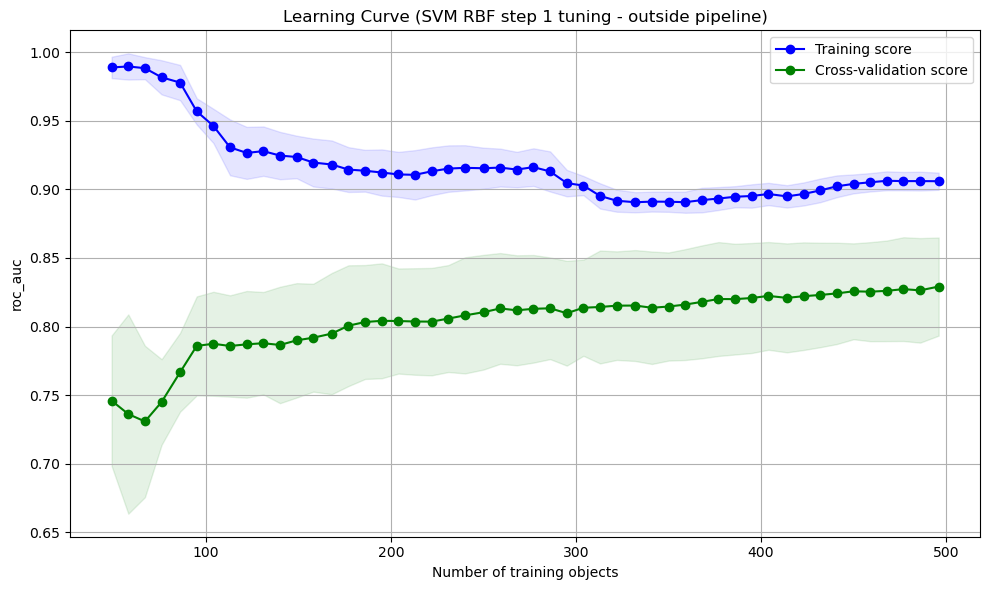

In [18]:
# step 1 of tuned RBF kernel outside the pipeline
# ====== PIPELINE CHARACTERISTICS ======
svm = SVC(
    kernel="rbf",
    random_state=42,
    class_weight='balanced'
)

# ====== PIPELINE  ======
pipeline = Pipeline([
    ('classifier', svm)
])

# ====== HYPERPARAMETER ======
param_grid = {
    'classifier__C': [0.1, 1, 10, 100, 1000],
    'classifier__gamma': [1e-4, 1e-3, 1e-2, 0.1, 1],
    'classifier__tol': [1e-3, 1e-4, 1e-5],
    'classifier__max_iter': [10000, 20000, -1]
}

# ====== 3. RANDOMIZED SEARCH MET CROSS-VALIDATIE ======
random_search = RandomizedSearchCV(
    estimator=pipeline,
    param_distributions=param_grid,
    n_iter=20,
    scoring='roc_auc',
    cv=cv,
    n_jobs=-1,
    verbose=1,
    refit=True
)

# ====== 4. TRAINING ======
random_search.fit(X_selected, y_train)

# ====== 5. RESULTATEN ======
print("Best estimator:\n", random_search.best_estimator_)
print("Best ROC AUC-score:", random_search.best_score_)
print("Best hyperparameters:", random_search.best_params_)
print("Mean ROC AUC:", random_search.cv_results_['mean_test_score'].mean())

# ====== 6. LEARNING CURVE PLOT ======
plot_learning_curve(
    X_selected,
    y_train,
    classifier=random_search.best_estimator_,
    scoring='roc_auc',
    clf_type='SVM RBF step 1 tuning - outside pipeline'
)

Fitting 5 folds for each of 20 candidates, totalling 100 fits
Best estimator:
 Pipeline(steps=[('classifier',
                 SVC(C=0.1, class_weight='balanced', gamma=0.1,
                     random_state=42))])
Best ROC AUC-score: 0.8290724409799223
Best hyperparameters: {'classifier__tol': 0.001, 'classifier__max_iter': -1, 'classifier__gamma': 0.1, 'classifier__C': 0.1}
Mean ROC AUC: 0.8030277009303278


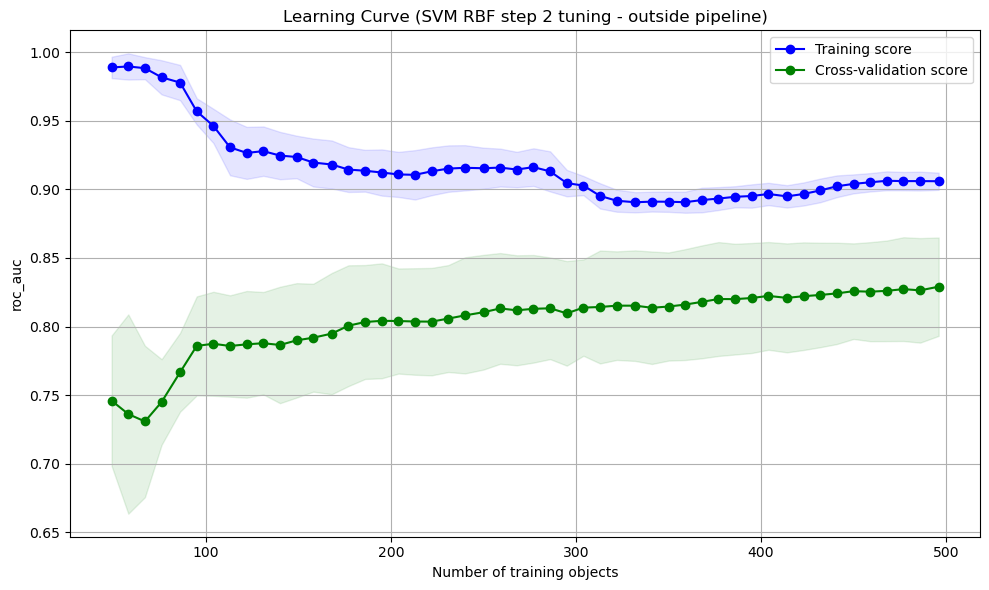

In [19]:
# step 2 of tuned RBF kernel outside the pipeline
# ====== SVM & Pipeline Setup ======
pipeline = Pipeline([
    ('classifier', SVC(kernel='rbf', class_weight='balanced', random_state=42))
])

# ====== Hyperparameter ======
param_grid = {
    'classifier__C': [0.01, 0.1, 1, 10, 100],
    'classifier__gamma': [1e-5, 1e-4, 1e-3, 1e-2, 0.1],
    'classifier__tol': [1e-3, 1e-4, 1e-5],
    'classifier__max_iter': [1000, 10000, -1]
}

# ====== Randomized Search CV ======
random_search = RandomizedSearchCV(
    estimator=pipeline,
    param_distributions=param_grid,
    n_iter=20,            
    scoring='roc_auc',
    cv=cv,                 
    n_jobs=-1,
    verbose=1,
    refit=True
)

# ====== Fit model op trainingsdata ======
random_search.fit(X_selected, y_train)

# ====== Resultaten tonen ======
print("Best estimator:\n", random_search.best_estimator_)
print("Best ROC AUC-score:", random_search.best_score_)
print("Best hyperparameters:", random_search.best_params_)
print("Mean ROC AUC:", random_search.cv_results_['mean_test_score'].mean())

# ====== LEARNING CURVE PLOT ======
plot_learning_curve(
    X_selected,
    y_train,
    classifier=random_search.best_estimator_,
    scoring='roc_auc',
    clf_type='SVM RBF step 2 tuning - outside pipeline'
)

Fitting 5 folds for each of 20 candidates, totalling 100 fits
New Best estimator:
 Pipeline(steps=[('classifier',
                 SVC(C=4, class_weight='balanced', gamma=0.0085, max_iter=80000,
                     random_state=42, tol=0.0003))])
New best ROC AUC-score: 0.8177733935586591
New best hyperparameters: {'classifier__tol': 0.0003, 'classifier__max_iter': 80000, 'classifier__gamma': 0.0085, 'classifier__C': 4}
Mean ROC AUC: 0.8165574835406361


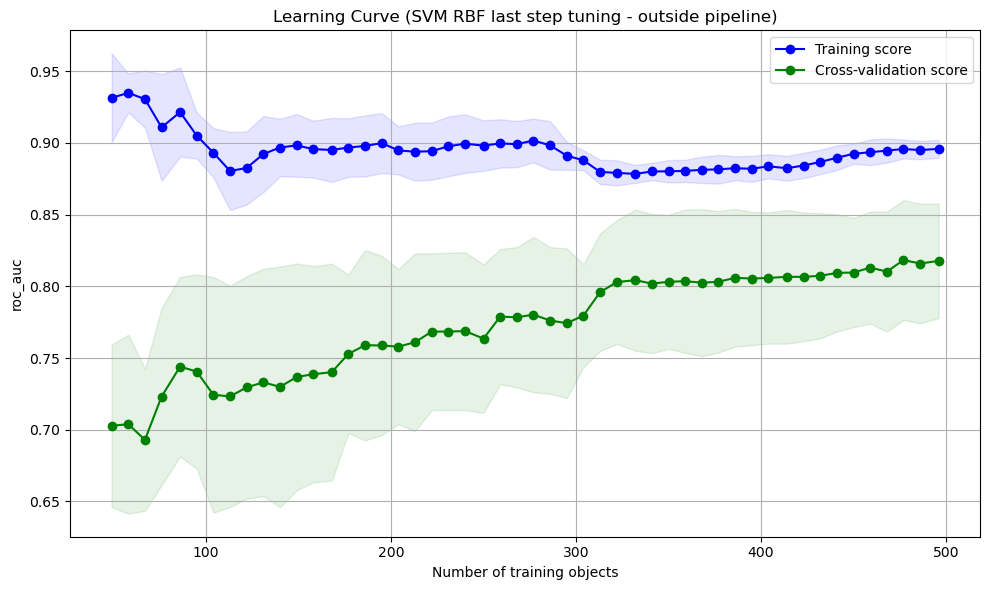

In [20]:
# last step of tuned RBF kernel outside the pipeline
# ====== SVM & Pipeline Setup ======
pipeline = Pipeline([
    ('classifier', SVC(kernel='rbf', class_weight='balanced', random_state=42))
])

# ====== Nog fijnmaziger Hyperparameter Ruimte ======
param_grid = {
    'classifier__C': [4, 4.5, 5],
    'classifier__gamma': [0.0085, 0.009, 0.0095],
    'classifier__tol': [3e-4, 5e-4, 7e-4],
    'classifier__max_iter': [80000, 10000, -1]
}

# ====== Randomized Search CV ======
random_search = RandomizedSearchCV(
    estimator=pipeline,
    param_distributions=param_grid,
    n_iter=20,
    scoring='roc_auc',
    cv=cv,
    n_jobs=-1,
    verbose=1,
    refit=True,
    random_state=42
)

# ====== Fit model op trainingsdata ======
random_search.fit(X_selected, y_train)

# ====== Resultaten tonen ======
print("New Best estimator:\n", random_search.best_estimator_)
print("New best ROC AUC-score:", random_search.best_score_)
print("New best hyperparameters:", random_search.best_params_)
print("Mean ROC AUC:", random_search.cv_results_['mean_test_score'].mean())


# ====== 6. LEARNING CURVE PLOT ======
plot_learning_curve(
    X_selected,
    y_train,
    classifier=random_search.best_estimator_,
    scoring='roc_auc',
    clf_type='SVM RBF last step tuning - outside pipeline'
)

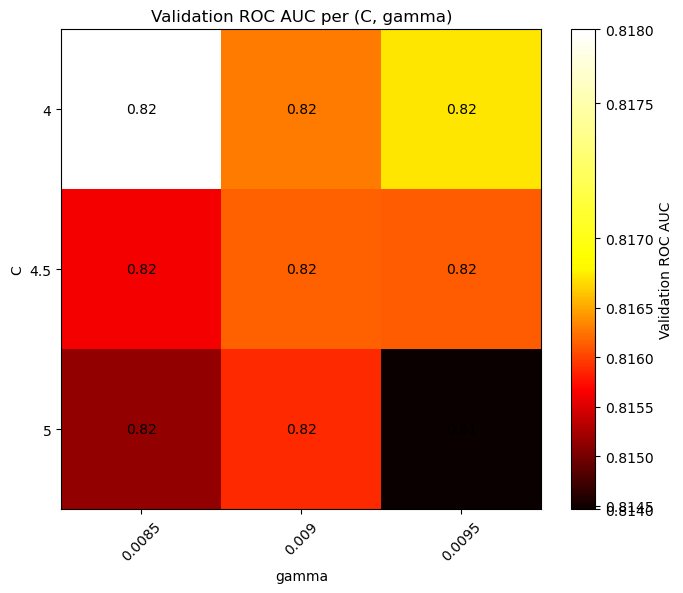

In [21]:
# code for hyperparameter tuning of rbf
# ===== MidpointNormalize class =====
class MidpointNormalize(Normalize):
    def __init__(self, vmin=None, vmax=None, midpoint=None, clip=False):
        self.midpoint = midpoint
        super().__init__(vmin, vmax, clip)

    def __call__(self, value, clip=None):
        return np.ma.masked_array(np.interp(value, [self.vmin, self.midpoint, self.vmax], [0, 0.5, 1]))

# ===== Extract C and gamma ranges from param_grid =====
C_range = param_grid['classifier__C']
gamma_range = param_grid['classifier__gamma']

scores = np.full((len(C_range), len(gamma_range)), np.nan)  # initialize with NaN

for idx, result in enumerate(random_search.cv_results_['params']):
    c_val = result['classifier__C']
    gamma_val = result['classifier__gamma']
    if c_val in C_range and gamma_val in gamma_range:
        c_idx = C_range.index(c_val)
        gamma_idx = gamma_range.index(gamma_val)
        scores[c_idx, gamma_idx] = random_search.cv_results_['mean_test_score'][idx]

# ===== Plot heatmap =====
plt.figure(figsize=(8, 6))
plt.subplots_adjust(left=0.2, right=0.95, bottom=0.15, top=0.95)

plt.imshow(
    scores,
    interpolation="nearest",
    cmap=plt.cm.hot,
    norm=MidpointNormalize(
        vmin=np.nanmin(scores),
        midpoint=np.nanmedian(scores),
        vmax=np.nanmax(scores)
    )
)

plt.xlabel("gamma")
plt.ylabel("C")
plt.colorbar(label='Validation ROC AUC')
plt.xticks(np.arange(len(gamma_range)), gamma_range, rotation=45)
plt.yticks(np.arange(len(C_range)), C_range)
plt.title("Validation ROC AUC per (C, gamma)")

# ===== ROC =====
for i in range(len(C_range)):
    for j in range(len(gamma_range)):
        if not np.isnan(scores[i, j]):
            plt.text(j, i, f"{scores[i, j]:.2f}", ha='center', va='center', color='black')

plt.show()

# KNN

In [8]:
labels = data.iloc[:,-1]
x = data.iloc[:,:-1]

X_train, X_test, y_train, y_test = train_test_split(x, labels, test_size=0.25, stratify=labels, random_state=42)
print(X_test.shape)
print(X_train.shape)

(207, 9000)
(620, 9000)


ROC AUC scores per fold: [0.68627451 0.72459893 0.63814617 0.63814617 0.81021729]
Gemiddelde ROC AUC: 0.6994766132401768


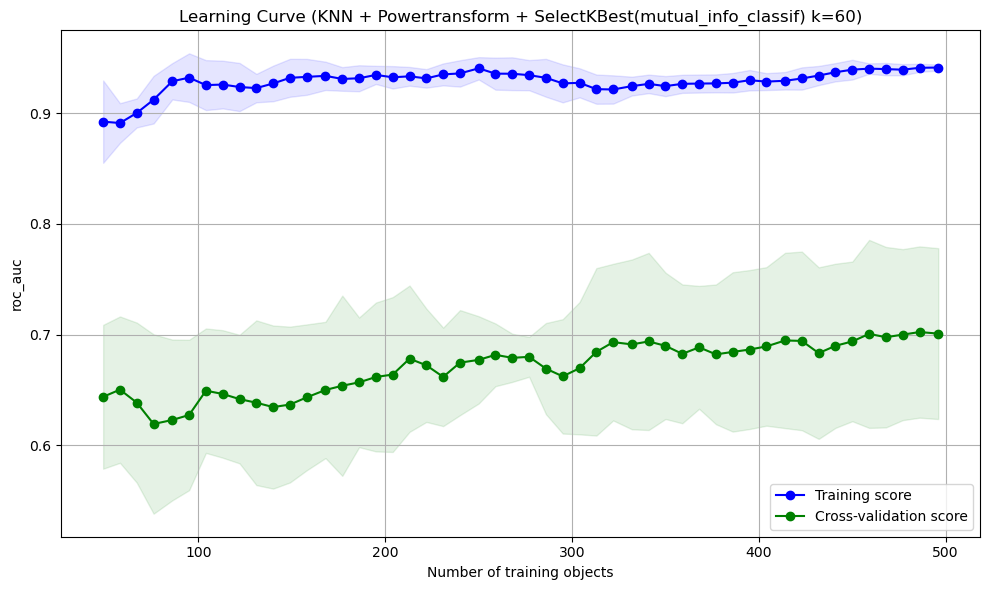

In [8]:
#choose between Robustscaling and powertransform, met mutual_info_classif, k=60
#Powertransform
selector = SelectKBest(score_func=mutual_info_classif, k=60)
X_train_reduced = selector.fit_transform(X_train, y_train)
X_test_reduced = selector.transform(X_test)

knn = Pipeline([
    ('power_transformer', PowerTransformer(method='yeo-johnson')),
    ('classifier', KNeighborsClassifier()),
    
])

scores = cross_val_score(
    knn,
    X_train_reduced,
    y_train,
    cv=StratifiedKFold(n_splits=5),
    scoring='roc_auc',
    n_jobs=-1
)

knn.fit(X_train_reduced, y_train)

print("ROC AUC scores per fold:", scores)
print("Gemiddelde ROC AUC:", scores.mean())

plot_learning_curve(X_train_reduced, y_train, classifier=knn, scoring='roc_auc', clf_type='KNN + Powertransform + SelectKBest(mutual_info_classif) k=60')

ROC AUC scores per fold: [0.57352941 0.71813725 0.68917112 0.67156863 0.80189552]
Gemiddelde ROC AUC: 0.6908603865200096


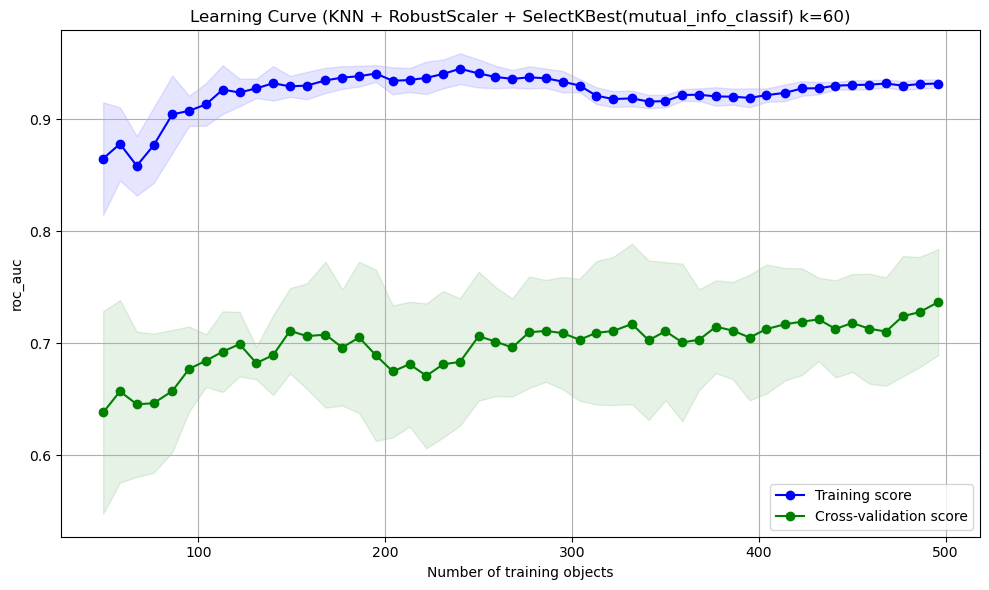

In [10]:
#choose between Robustscaling and powertransform, met mutual_info_classif, k=60
#RobustScaling
selector = SelectKBest(score_func=mutual_info_classif, k=60)
X_train_reduced = selector.fit_transform(X_train, y_train)
X_test_reduced = selector.transform(X_test)

knn = Pipeline([
    ('scaler', RobustScaler()),
    ('classifier', KNeighborsClassifier()),
    
])

scores = cross_val_score(
    knn,
    X_train_reduced,
    y_train,
    cv=StratifiedKFold(n_splits=5),
    scoring='roc_auc',
    n_jobs=-1
)

knn.fit(X_train_reduced, y_train)

print("ROC AUC scores per fold:", scores)
print("Gemiddelde ROC AUC:", scores.mean())

plot_learning_curve(X_train_reduced, y_train, classifier=knn, scoring='roc_auc', clf_type='KNN + RobustScaler + SelectKBest(mutual_info_classif) k=60')

ROC AUC scores per fold: [0.65307487 0.72727273 0.64349376 0.66778075 0.72538141]
Gemiddelde ROC AUC: 0.6834007036177224


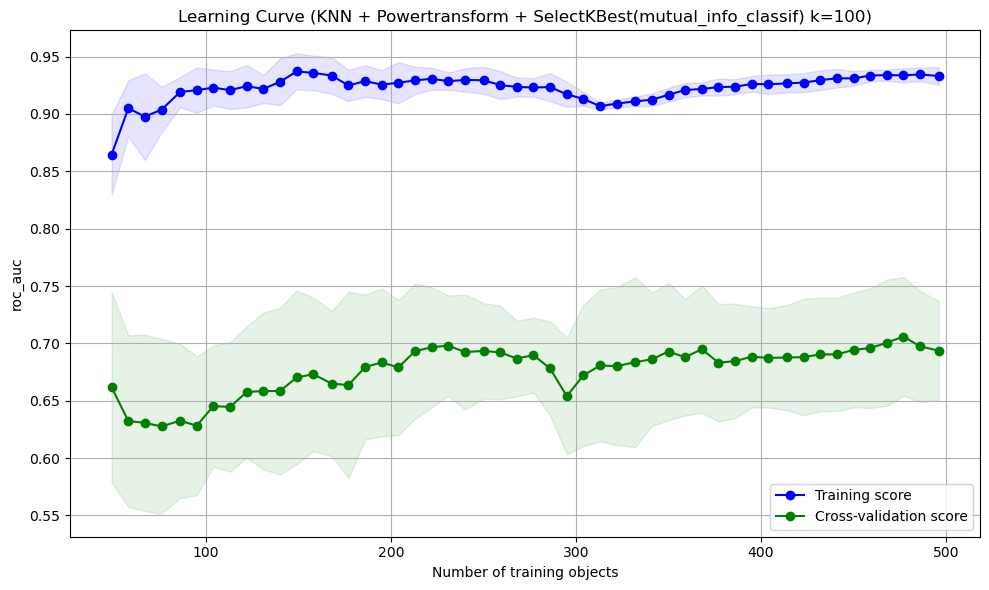

In [11]:
#Feature selection --> Select the best k=100 
#feature selection with mutual_info_classif, == 100 features
selector = SelectKBest(score_func=mutual_info_classif, k=100)
X_train_reduced = selector.fit_transform(X_train, y_train)
X_test_reduced = selector.transform(X_test)

knn = Pipeline([
    ('power_transformer', PowerTransformer(method='yeo-johnson')),
    ('classifier', KNeighborsClassifier()), 
])


knn.fit(X_train_reduced, y_train)

scores = cross_val_score(
    knn,
    X_train_reduced,
    y_train,
    cv=StratifiedKFold(n_splits=5),
    scoring='roc_auc',
    n_jobs=-1
)

print("ROC AUC scores per fold:", scores)
print("Gemiddelde ROC AUC:", scores.mean())

plot_learning_curve(X_train_reduced, y_train, classifier=knn, scoring='roc_auc', clf_type='KNN + Powertransform + SelectKBest(mutual_info_classif) k=100')

ROC AUC scores per fold: [0.64683601 0.77918895 0.66399287 0.66911765 0.73254739]
Gemiddelde ROC AUC: 0.6983365720515919


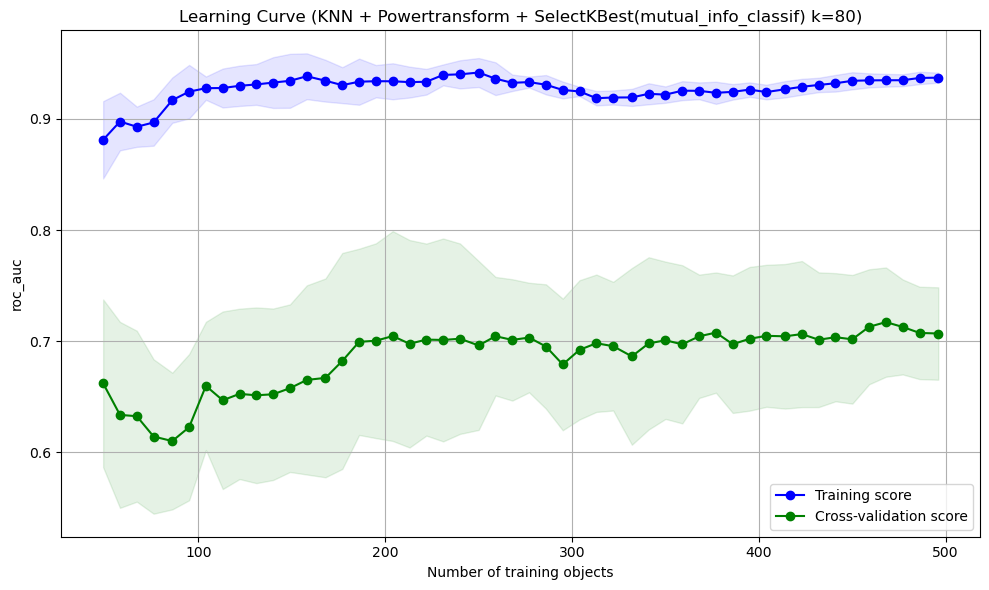

In [12]:
#Feature selection --> Select the best k=80 
#Powertransform
selector = SelectKBest(score_func=mutual_info_classif, k=80)
X_train_reduced = selector.fit_transform(X_train, y_train)
X_test_reduced = selector.transform(X_test)

knn = Pipeline([
    ('power_transformer', PowerTransformer(method='yeo-johnson')),
    ('classifier', KNeighborsClassifier()), 
])

knn.fit(X_train_reduced, y_train)

scores = cross_val_score(
    knn,
    X_train_reduced,
    y_train,
    cv=StratifiedKFold(n_splits=5),
    scoring='roc_auc',
    n_jobs=-1
)

print("ROC AUC scores per fold:", scores)
print("Gemiddelde ROC AUC:", scores.mean())

plot_learning_curve(X_train_reduced, y_train, classifier=knn, scoring='roc_auc', clf_type='KNN + Powertransform + SelectKBest(mutual_info_classif) k=80')

ROC AUC scores per fold: [0.68627451 0.72459893 0.63814617 0.63814617 0.81021729]
Gemiddelde ROC AUC: 0.6994766132401768


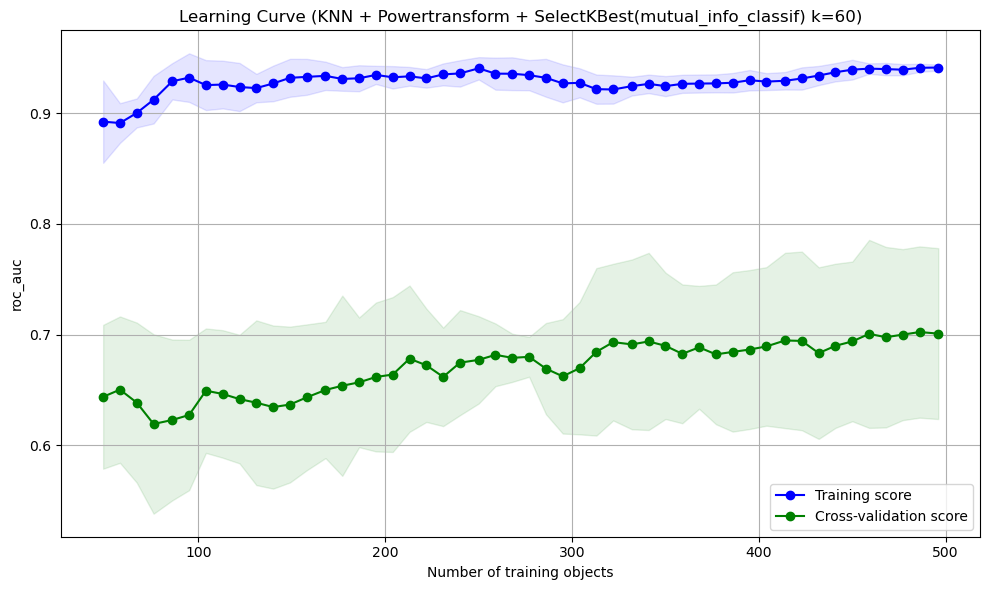

In [13]:
#Feature selection --> Select the best k=60 
#Powertransform
#Powertransform
selector = SelectKBest(score_func=mutual_info_classif, k=60)
X_train_reduced = selector.fit_transform(X_train, y_train)
X_test_reduced = selector.transform(X_test)

knn = Pipeline([
    ('power_transformer', PowerTransformer(method='yeo-johnson')),
    ('classifier', KNeighborsClassifier()), 
])

knn.fit(X_train_reduced, y_train)

scores = cross_val_score(
    knn,
    X_train_reduced,
    y_train,
    cv=StratifiedKFold(n_splits=5), 
    scoring='roc_auc',
    n_jobs=-1
)

print("ROC AUC scores per fold:", scores)
print("Gemiddelde ROC AUC:", scores.mean())

plot_learning_curve(X_train_reduced, y_train, classifier=knn, scoring='roc_auc', clf_type='KNN + Powertransform + SelectKBest(mutual_info_classif) k=60')

ROC AUC scores per fold: [0.72214795 0.76938503 0.65463458 0.64884135 0.80698104]
Gemiddelde ROC AUC: 0.7203979915002188


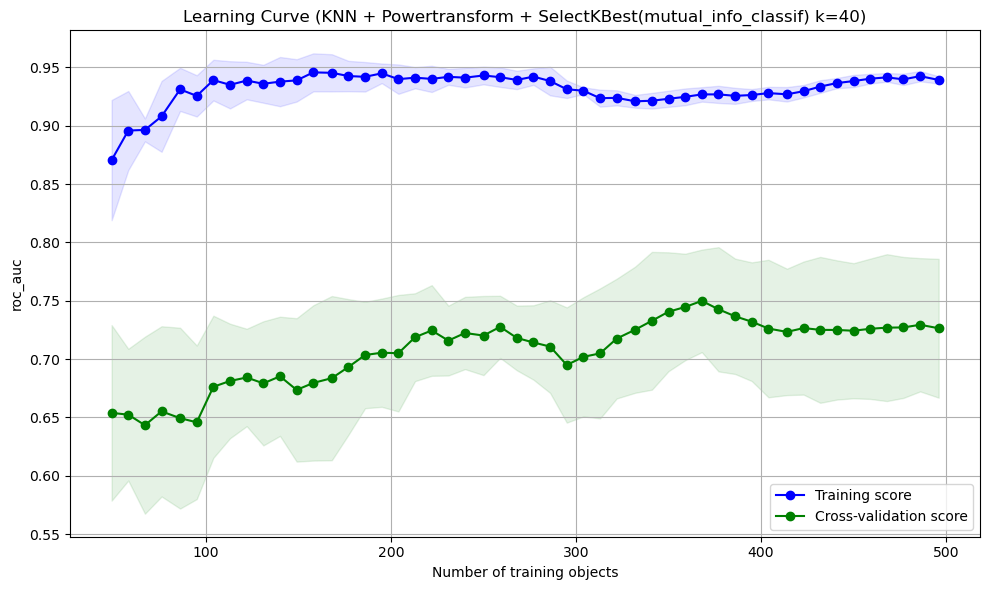

In [14]:
#Feature selection --> Select the best k=40 
#Powertransform
selector = SelectKBest(score_func=mutual_info_classif, k=40)
X_train_reduced = selector.fit_transform(X_train, y_train)
X_test_reduced = selector.transform(X_test)

knn = Pipeline([
    ('power_transformer', PowerTransformer(method='yeo-johnson')),
    ('classifier', KNeighborsClassifier()), 
])

knn.fit(X_train_reduced, y_train)

scores = cross_val_score(
    knn,
    X_train_reduced,
    y_train,
    cv=StratifiedKFold(n_splits=5),
    scoring='roc_auc',
    n_jobs=-1
)

print("ROC AUC scores per fold:", scores)
print("Gemiddelde ROC AUC:", scores.mean())

plot_learning_curve(X_train_reduced, y_train, classifier=knn, scoring='roc_auc', clf_type='KNN + Powertransform + SelectKBest(mutual_info_classif) k=40')

ROC AUC scores per fold: [0.67647059 0.7676025  0.64438503 0.68917112 0.71104947]
Gemiddelde ROC AUC: 0.6977357403685216


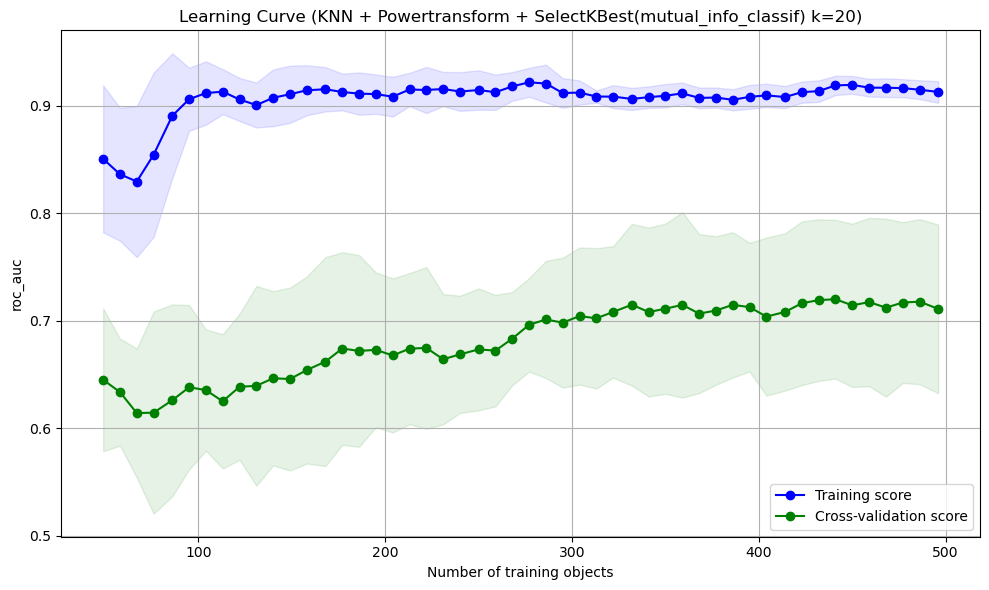

In [15]:
#Feature selection --> Select the best k=20
#Powertransform
selector = SelectKBest(score_func=mutual_info_classif, k=20)
X_train_reduced = selector.fit_transform(X_train, y_train)
X_test_reduced = selector.transform(X_test)

knn = Pipeline([
    ('power_transformer', PowerTransformer(method='yeo-johnson')),
    ('classifier', KNeighborsClassifier()), 
])

knn.fit(X_train_reduced, y_train)

scores = cross_val_score(
    knn,
    X_train_reduced,
    y_train,
    cv=StratifiedKFold(n_splits=5), 
    scoring='roc_auc',
    n_jobs=-1
)

print("ROC AUC scores per fold:", scores)
print("Gemiddelde ROC AUC:", scores.mean())

plot_learning_curve(X_train_reduced, y_train, classifier=knn, scoring='roc_auc', clf_type='KNN + Powertransform + SelectKBest(mutual_info_classif) k=20')

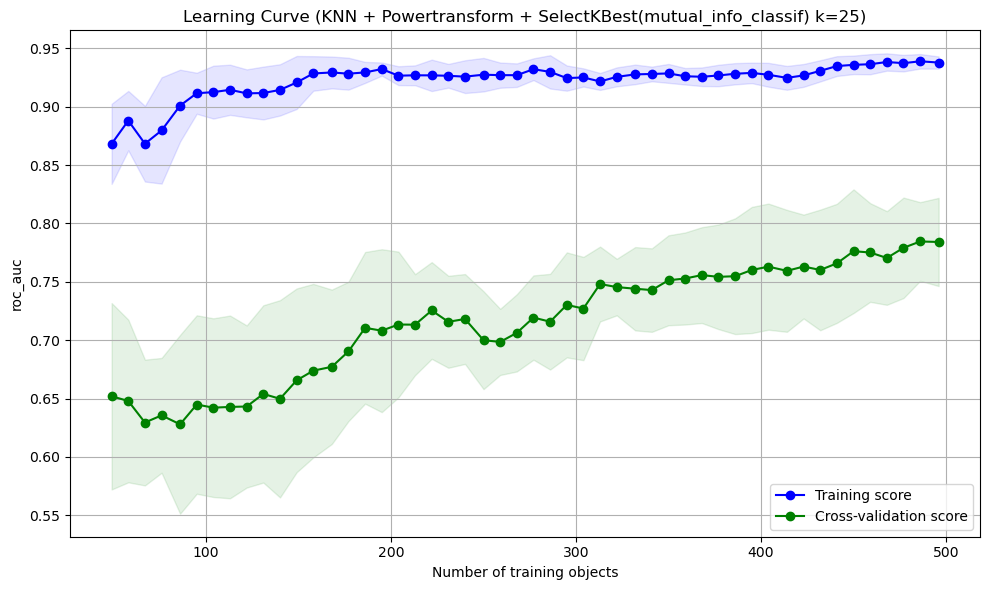

Gemiddelde ROC AUC: 0.7606159498221178


In [16]:
#Feature selection --> Select the best k=25
#Powertransform
selector = SelectKBest(score_func=mutual_info_classif, k=25)
X_train_reduced = selector.fit_transform(X_train, y_train)
X_test_reduced = selector.transform(X_test)

knn = Pipeline([
    ('power_transformer', PowerTransformer(method='yeo-johnson')),
    ('classifier', KNeighborsClassifier()), 
])

knn.fit(X_train_reduced, y_train)

scores = cross_val_score(
    knn,
    X_train_reduced,
    y_train,
    cv=StratifiedKFold(n_splits=5),
    scoring='roc_auc',
    n_jobs=-1
)

plot_learning_curve(X_train_reduced, y_train, classifier=knn, scoring='roc_auc', clf_type='KNN + Powertransform + SelectKBest(mutual_info_classif) k=25')
print("Gemiddelde ROC AUC:", scores.mean())

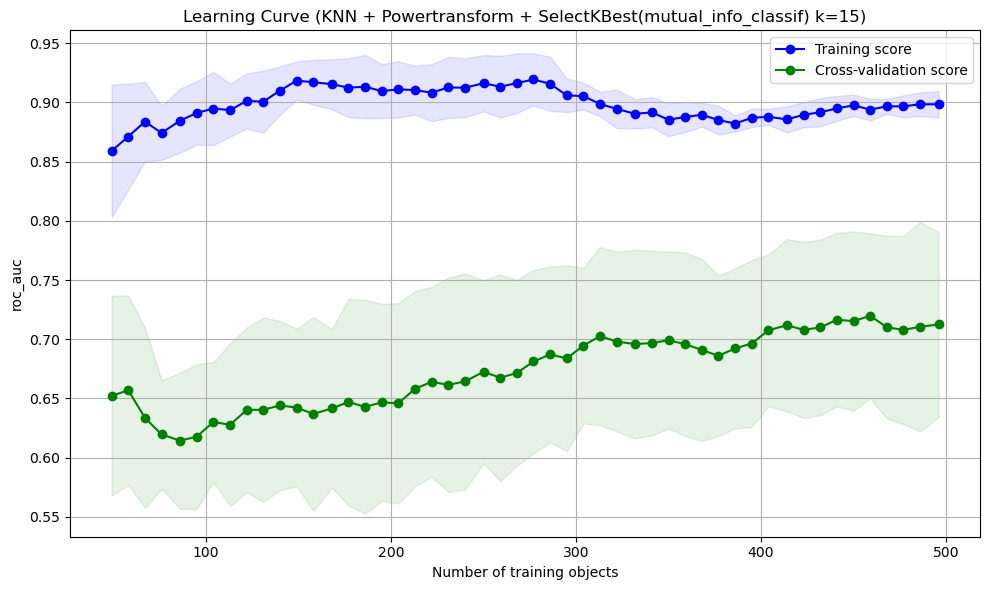

Gemiddelde ROC AUC: 0.6879015948833196


In [17]:
#Feature selection --> Select the best k=15
#Powertransform
selector = SelectKBest(score_func=mutual_info_classif, k=15)
X_train_reduced = selector.fit_transform(X_train, y_train)
X_test_reduced = selector.transform(X_test)

knn = Pipeline([
    ('power_transformer', PowerTransformer(method='yeo-johnson')),
    ('classifier', KNeighborsClassifier()), 
])

knn.fit(X_train_reduced, y_train) 

scores = cross_val_score(
    knn,
    X_train_reduced,
    y_train,
    cv=StratifiedKFold(n_splits=5), 
    scoring='roc_auc',
    n_jobs=-1
)

plot_learning_curve(X_train_reduced, y_train, classifier=knn, scoring='roc_auc', clf_type='KNN + Powertransform + SelectKBest(mutual_info_classif) k=15')
print("Gemiddelde ROC AUC:", scores.mean())

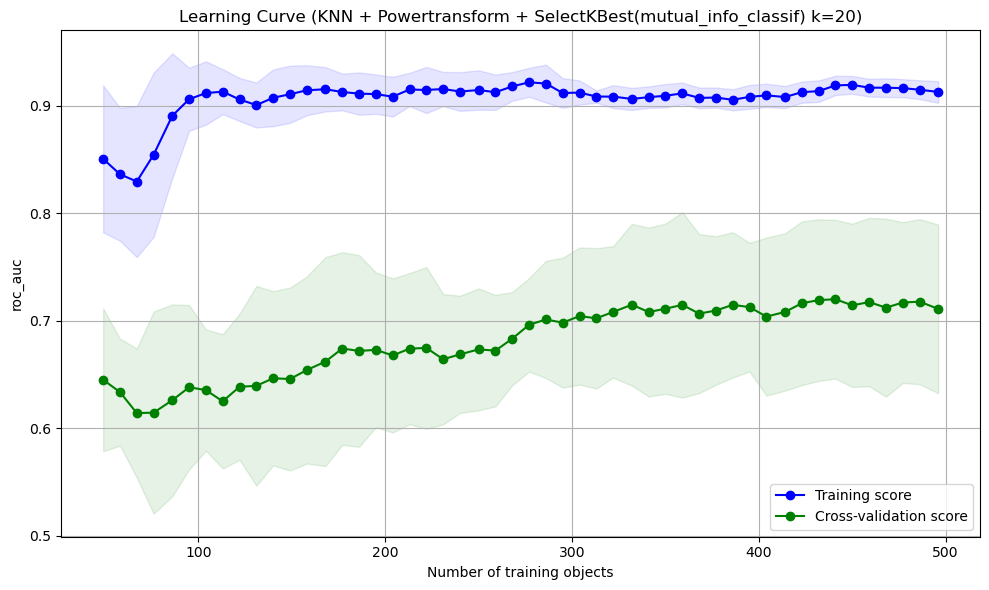

Gemiddelde ROC AUC: 0.6977357403685216


In [18]:
#Feature selection --> Select the best k=20
#Powertransform
selector = SelectKBest(score_func=mutual_info_classif, k=20)
X_train_reduced = selector.fit_transform(X_train, y_train)
X_test_reduced = selector.transform(X_test)

knn = Pipeline([
    ('power_transformer', PowerTransformer(method='yeo-johnson')),
    ('classifier', KNeighborsClassifier()), 
])

knn.fit(X_train_reduced, y_train)

scores = cross_val_score(
    knn,
    X_train_reduced,
    y_train,
    cv=StratifiedKFold(n_splits=5),
    scoring='roc_auc',
    n_jobs=-1
)

plot_learning_curve(X_train_reduced, y_train, classifier=knn, scoring='roc_auc', clf_type='KNN + Powertransform + SelectKBest(mutual_info_classif) k=20')
print("Gemiddelde ROC AUC:", scores.mean())

In [9]:
#Hyperparameter tuning
knn = Pipeline([
    ('scaler', PowerTransformer(method='yeo-johnson')),
    ('feature_selection', SelectKBest(mutual_info_classif, k=25)),
    ('classifier', KNeighborsClassifier())
])

parameters = {
    'classifier__n_neighbors': [13, 15, 17, 19, 21, 23, 25, 27, 29, 31],
    'classifier__weights': ['uniform', 'distance'],
    'classifier__metric': ['euclidean', 'manhattan', 'chebyshev', 'minkowski'],     
    } 

model = RandomizedSearchCV(
    estimator=knn,
    param_distributions=parameters,
    n_iter=10,
    n_jobs=-1,
    cv=StratifiedKFold(n_splits=5, shuffle=True, random_state=42),
    scoring='roc_auc'  
)

model.fit(X_train, y_train)

print("Best estimator:", model.best_estimator_ )
print("Best ROC_AUC Score:", model.best_score_)
print("best parameters:", model.best_params_)

plot_learning_curve(X_train, y_train, classifier=model, scoring='roc_auc', clf_type='KNN + hyperparameter tuning')

Best estimator: Pipeline(steps=[('scaler', PowerTransformer()),
                ('feature_selection',
                 SelectKBest(k=25,
                             score_func=<function mutual_info_classif at 0x0000029DB2F7CC20>)),
                ('classifier',
                 KNeighborsClassifier(metric='manhattan', n_neighbors=23,
                                      weights='distance'))])
Best ROC_AUC Score: 0.744239593454328
best parameters: {'classifier__weights': 'distance', 'classifier__n_neighbors': 23, 'classifier__metric': 'manhattan'}


KeyboardInterrupt: 

In [ ]:
def optimize_knn(X_train, y_train):
    pipe = Pipeline([
        ('scaler', PowerTransformer(method='yeo-johnson')),
        ('feature_selection', SelectKBest(mutual_info_classif, k=25)),
        ('classifier', KNeighborsClassifier())
    ])

    param_dist = {
        'classifier__n_neighbors': [3, 5, 7, 9, 11, 13, 15, 17, 19, 21],
        'classifier__weights': ['uniform', 'distance'],
        'classifier__metric': ['euclidean', 'manhattan', 'chebyshev', 'minkowski'],     
    } 

    n_iterations = 20

    random_search = RandomizedSearchCV(
                                        pipe, 
                                        param_distributions=param_dist, 
                                        cv=StratifiedKFold(n_splits=5, shuffle=True, random_state=42),
                                        n_iter=n_iterations,
                                        scoring='roc_auc', 
                                        n_jobs=-1,
                                        random_state=42
                                        )
    random_search.fit(X_train, y_train)
 
    print("Best Parameters:", random_search.best_params_)
    print("Best Score:", random_search.best_score_)
    return random_search.best_estimator_    


Best Parameters: {'classifier__weights': 'uniform', 'classifier__n_neighbors': 21, 'classifier__metric': 'euclidean'}
Best Score: 0.7028792375176666
Accuracy:  0.861
Precision: 1.000
Recall:    0.207
F1 Score:  0.343
AUC Score: 0.768
Best Parameters: {'classifier__weights': 'distance', 'classifier__n_neighbors': 19, 'classifier__metric': 'minkowski'}
Best Score: 0.7785666799627708
Accuracy:  0.855
Precision: 1.000
Recall:    0.200
F1 Score:  0.333
AUC Score: 0.682
Best Parameters: {'classifier__weights': 'uniform', 'classifier__n_neighbors': 15, 'classifier__metric': 'euclidean'}
Best Score: 0.6865958649115809
Accuracy:  0.848
Precision: 1.000
Recall:    0.138
F1 Score:  0.242
AUC Score: 0.788
Best Parameters: {'classifier__weights': 'distance', 'classifier__n_neighbors': 11, 'classifier__metric': 'euclidean'}
Best Score: 0.7358928333998138
Accuracy:  0.861
Precision: 0.750
Recall:    0.310
F1 Score:  0.439
AUC Score: 0.680
Best Parameters: {'classifier__weights': 'distance', 'classifi

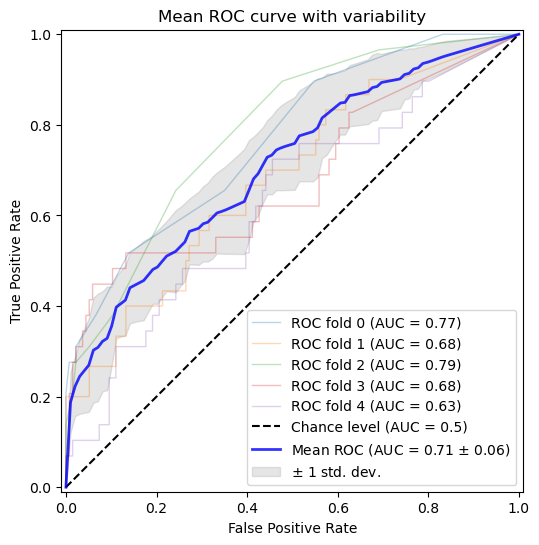

In [ ]:
#Perform hyperparameter optimization and plot mean ROC curve with variability
X = data.iloc[:,:-1]
y = data.iloc[:,-1]

X_train, y_train, best_classifier = plot_roc_cv(X, y, optimize_knn, n_splits=5)

### Unused code KNN:

In [ ]:
#Optie 1: Feature selection with SelectKBest mutual_info_classif, k=100

knn = Pipeline([
    ('scaler', RobustScaler()),
    ('feature_selection', SelectKBest(mutual_info_classif, k=100)),
    ('classifier', KNeighborsClassifier())
])


scores = cross_val_score(
    knn,
    X_train,
    y_train,
    cv=StratifiedKFold(n_splits=5, shuffle=True, random_state=42),
    scoring='roc_auc',
    n_jobs=-1
)

print("ROC AUC scores per fold:", scores)
print("Mean ROC AUC:", scores.mean())

plot_learning_curve(X_train, y_train, classifier=knn, scoring='error', clf_type='KNN + SelectKBest(mutual_info_classif, k=100)')


In [ ]:
#Optie 2: Feature selection: pre-feature selection (f_classif, k=200) and with SelectKBest mutual_info_classif, k=100
selector = SelectKBest(score_func=f_classif, k=200)
X_train_reduced = selector.fit_transform(X_train, y_train)
X_test_reduced = selector.transform(X_test)

knn = Pipeline([
    ('scaler', RobustScaler()),
    ('feature_selection', SelectKBest(mutual_info_classif, k=100)),
    ('classifier', KNeighborsClassifier())
])


scores = cross_val_score(
    knn,
    X_train_reduced,
    y_train,
    cv=StratifiedKFold(n_splits=5, shuffle=True, random_state=42),
    scoring='roc_auc',
    n_jobs=-1
)

print("ROC AUC scores per fold:", scores)
print("Mean ROC AUC:", scores.mean())

plot_learning_curve(X_train_reduced, y_train, classifier=knn, scoring='error', clf_type='KNN + pre-feature selection (f_classif, k=200)+ SelectKBest(mutual_info_classif, k=100)')


In [ ]:
#Optie 3: Feature selection with SelectKBest f_classif, k=100
knn = Pipeline([
    ('scaler', RobustScaler()),
    ('feature_selection', SelectKBest(f_classif, k=100)),
    ('classifier', KNeighborsClassifier())
])


scores = cross_val_score(
    knn,
    X_train,
    y_train,
    cv=StratifiedKFold(n_splits=5, shuffle=True, random_state=42),
    scoring='roc_auc',
    n_jobs=-1
)

print("ROC AUC scores per fold:", scores)
print("Mean ROC AUC:", scores.mean())

plot_learning_curve(X_train, y_train, classifier=knn, scoring='error', clf_type='KNN + SelectKBest(f_classif, k=100)')

In [ ]:
#Optie 2: Feature selection: pre-feature selection (f_classif, k=200) and with SelectKBest mutual_info_classif, k=100
#hyperparameter tuning with RandomizedSearchCV

selector = SelectKBest(score_func=f_classif, k=200)
X_train_reduced = selector.fit_transform(X_train, y_train)
X_test_reduced = selector.transform(X_test)

knn = Pipeline([
    ('scaler', RobustScaler()),
    ('feature_selection', SelectKBest(mutual_info_classif, k=100)),
    ('classifier', KNeighborsClassifier())
])

parameters = {
    'classifier__n_neighbors': [3, 5, 7, 9, 11, 13, 15, 17, 19, 21],
    'classifier__weights': ['uniform', 'distance'],
    'classifier__metric': ['euclidean', 'manhattan', 'chebyshev', 'minkowski'],     
    } 

model = RandomizedSearchCV(
    estimator=knn,
    param_distributions=parameters,
    n_iter=10,
    n_jobs=-1,
    cv=5,
    scoring='roc_auc' ,
    random_state=42 
)

model.fit(X_train, y_train)

print("Best estimator:", model.best_estimator_ )
print("Best ROC_AUC Score:", model.best_score_)
print("best parameters:", model.best_params_)

plot_learning_curve(X_train, y_train, classifier=knn, scoring='error', clf_type='KNN + hyperparameter tuning with RandomizedSearchCV + pre-feature selection (f_classif, k=200)+ SelectKBest(mutual_info_classif, k=100)')


# Random Forest

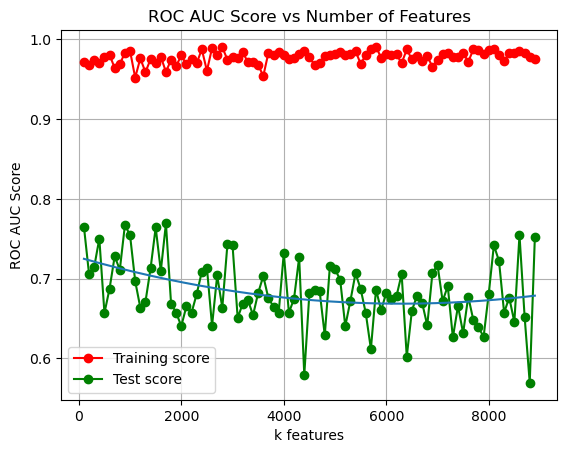

In [48]:
# Since the dataset contains 9000 features, it is likely that a large part of the features in the dataset contains no useful information. 
# If RF randomly selects these irrelevant features, we would introduce noise to our model and thus decrease the model performance. 
# To test this, the area under the receiver operating characteristics curve (ROC AUC) score was plotted for different numbers of features, 
# using a simple RF classifier (n_estimators=10, max_depth=10) and a train-test-split (test size 0.25).

labels = data.iloc[:,-1]
x = data.iloc[:,:-1]

X_train, X_test, y_train, y_test = train_test_split(x, labels, test_size=0.25, stratify=labels, random_state=42)

train_scores = []
test_scores = []
k_list = np.arange(100,9000,100)

# For each k features in the list, train a RF classifier and calculate the AUC score
for k in k_list:
    rf = Pipeline([
                ('feature_selection', SelectKBest(f_classif, k=k)), 
                ('rfc', RandomForestClassifier(n_estimators=10, max_depth=5, n_jobs=-1, random_state=42))
                ])
    rf.fit(X_train, y_train)
    train_scores.append(roc_auc_score(y_train, rf.predict_proba(X_train)[:,1]))
    test_scores.append(roc_auc_score(y_test, rf.predict_proba(X_test)[:,1]))

# Fit a trendline through the points of the test scores (since that is what we're interested in)
poly = np.polyfit(k_list, test_scores, deg=2)
poly_func = np.poly1d(poly)

k_smooth = np.linspace(k_list.min(), k_list.max(), 300)
test_scores_smooth = poly_func(k_smooth)

fig = plt.figure()
ax = fig.add_subplot(111)
ax.grid()
ax.plot(k_list, train_scores, 'o-', color="r",
        label="Training score")
ax.plot(k_list, test_scores, 'o-', color="g",
        label="Test score")
ax.plot(k_smooth, test_scores_smooth)
ax.set_title('ROC AUC Score vs Number of Features')
ax.set_xlabel('k features')
ax.set_ylabel('ROC AUC Score')
ax.legend()


For the Random Forest classifier, we decided to optimize:
- The number of features (k),
- The number of estimators (n_estimators),
- Minimum number of samples required for a split (min_samples_split), 
- Minimum number of samples required for a leaf (min_samples_leaf), 
- Maximum depth of each tree (max_depth),
- Function to measure the quality of a split (criterion), and
- Whether bootstrapping is used to train the trees (bootstrap).

In [ ]:
def optimize_rf(X_train, y_train):
    pipe = Pipeline([('feature_selection', SelectKBest(f_classif)), 
                 ('classifier', RandomForestClassifier(random_state=42, n_jobs=-1, max_features='sqrt', class_weight='balanced'))
                 ])

    param_dist = {
        'feature_selection__k': np.arange(50, 250, 10),
        'classifier__n_estimators': np.arange(5, 15, 5),
        'classifier__min_samples_split': np.arange(20, 50, 5),
        'classifier__min_samples_leaf': np.arange(20, 50, 5),
        'classifier__max_depth': [5, 10],
        'classifier__criterion': ['gini', 'entropy'],
        'classifier__bootstrap': [True, False]
    }

    n_iterations = 20

    random_search = RandomizedSearchCV(
                                        pipe, 
                                        param_distributions=param_dist, 
                                        cv=StratifiedKFold(n_splits=5, shuffle=True, random_state=42), 
                                        n_iter=n_iterations,
                                        scoring='roc_auc', 
                                        n_jobs=-1,
                                        random_state=42
                                        )
    random_search.fit(X_train, y_train)

    print("Best Parameters:", random_search.best_params_)
    print("Best Score:", random_search.best_score_)
    return random_search.best_estimator_


Best Parameters: {'feature_selection__k': 140, 'classifier__n_estimators': 10, 'classifier__min_samples_split': 45, 'classifier__min_samples_leaf': 40, 'classifier__max_depth': 5, 'classifier__criterion': 'gini', 'classifier__bootstrap': False}
Best Score: 0.7872425110923981
Accuracy:  0.789
Precision: 0.421
Recall:    0.552
F1 Score:  0.478
AUC Score: 0.765
Best Parameters: {'feature_selection__k': 160, 'classifier__n_estimators': 10, 'classifier__min_samples_split': 20, 'classifier__min_samples_leaf': 40, 'classifier__max_depth': 10, 'classifier__criterion': 'entropy', 'classifier__bootstrap': True}
Best Score: 0.8013429065283871
Accuracy:  0.729
Precision: 0.358
Recall:    0.633
F1 Score:  0.458
AUC Score: 0.773
Best Parameters: {'feature_selection__k': 180, 'classifier__n_estimators': 10, 'classifier__min_samples_split': 20, 'classifier__min_samples_leaf': 40, 'classifier__max_depth': 10, 'classifier__criterion': 'gini', 'classifier__bootstrap': True}
Best Score: 0.8123337986969817

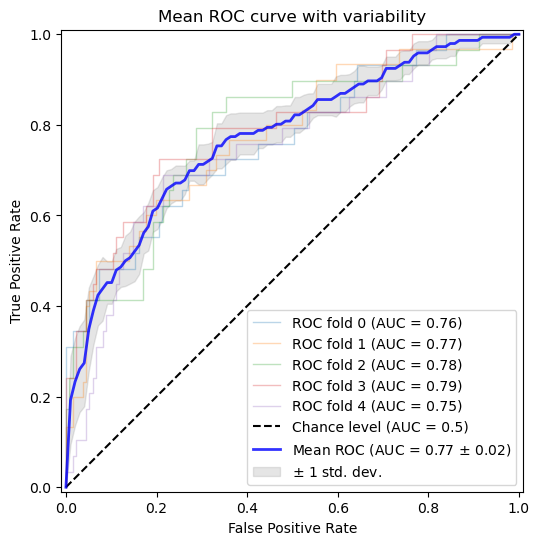

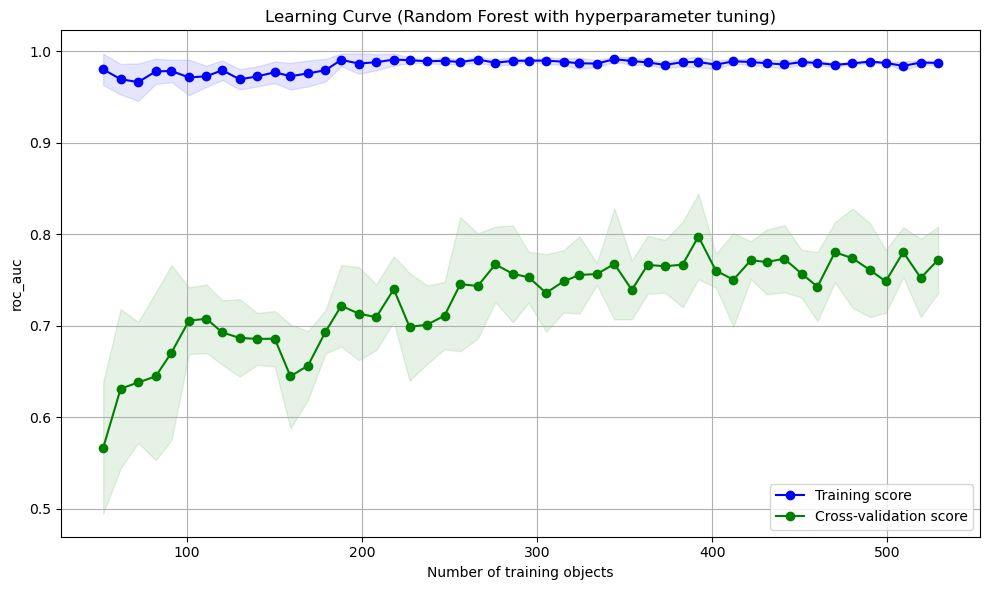

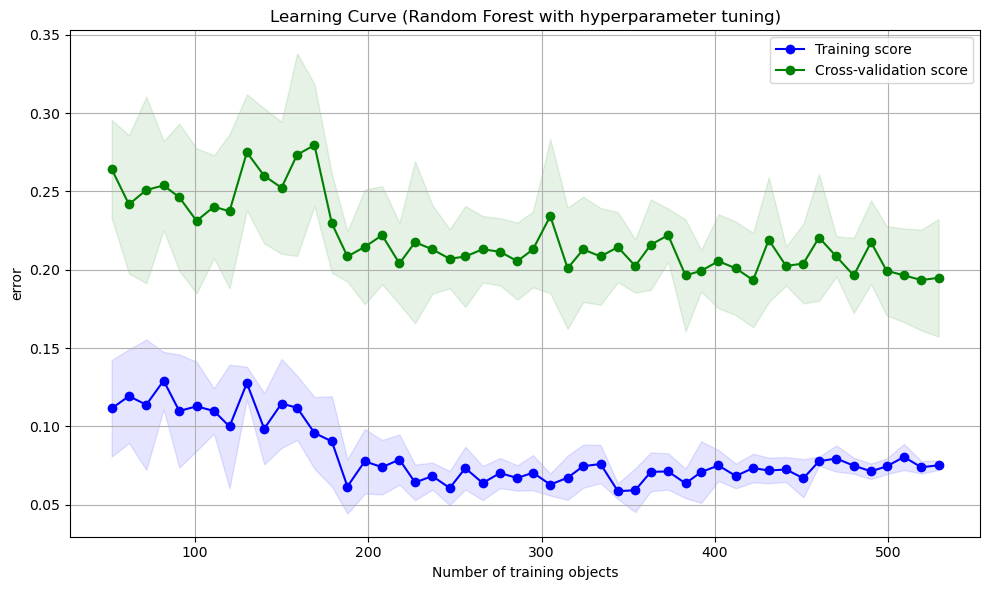

In [ ]:
# Perform the hyperparameter optimization and plot the ROC curves and learning curves
X = data.iloc[:,:-1]
y = data.iloc[:,-1]

X_train, y_train, best_classifier = plot_roc_cv(X, y, optimize_rf, n_splits=5)
plot_learning_curve(X_train, y_train, best_classifier, scoring='roc_auc', clf_type='Random Forest with hyperparameter tuning')
plot_learning_curve(X_train, y_train, best_classifier, scoring='error', clf_type='Random Forest with hyperparameter tuning')


## Unused Code for Random Forest

### Baseline RandomForest model
To check the performance of a simple model, a RandomForestClassifier with 10 estimators and a max depth of 5 was used. The same model was used to plot the AUC score vs the number of features.
The learning curves show a gradual decrease in the cross-validation error, but a fast increase in training error. This indicates that the model can be optimised to improve the performance.

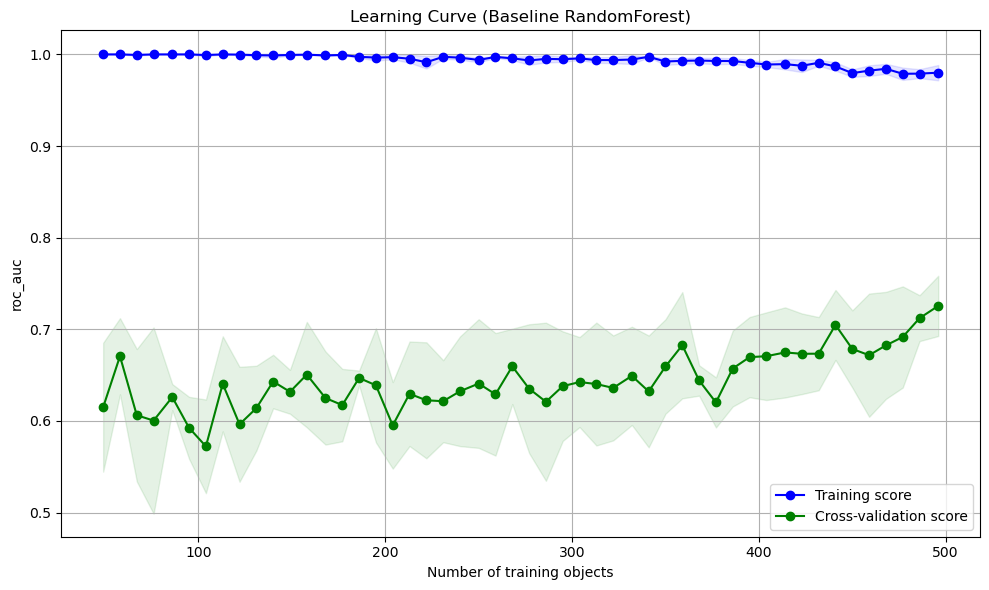

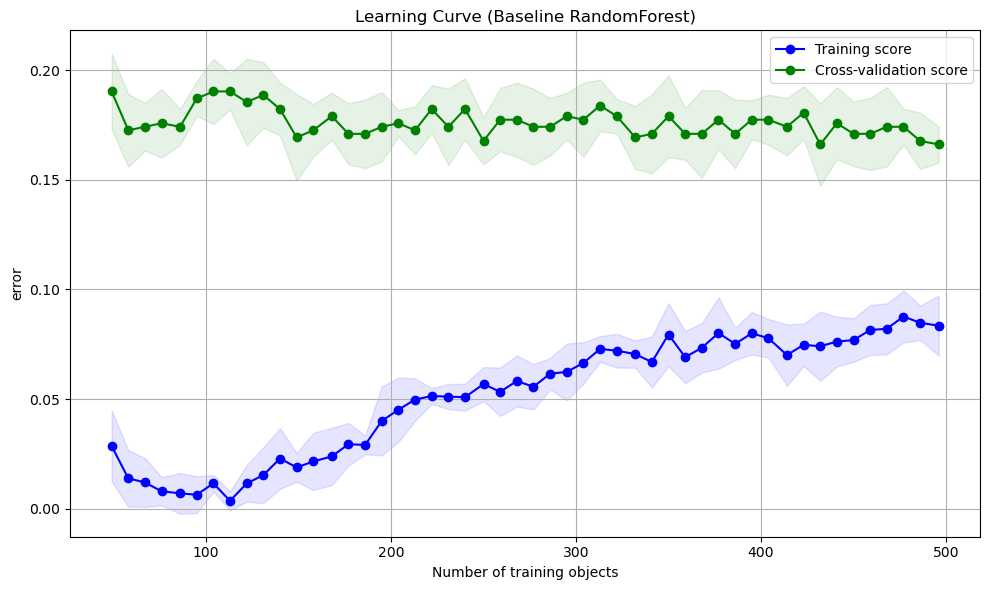

In [36]:
labels = data.iloc[:,-1]
x = data.iloc[:,:-1]

X_train, X_test, y_train, y_test = train_test_split(x, labels, test_size=0.25, stratify=labels, random_state=42)

rf = RandomForestClassifier(n_estimators=10, max_depth=5, n_jobs=-1, random_state=42)
rf.fit(X_train, y_train)

plot_learning_curve(X_train, y_train, rf, scoring='roc_auc', clf_type='Baseline RandomForest')
plot_learning_curve(X_train, y_train, rf, scoring='error', clf_type='Baseline RandomForest')

Old models with 2500 and 1000 features respectively, from the learning curves it can be concluded that this model is too complex and thus overfits on the training data

Best Parameters: {'feature_selection__k': 1950, 'classifier__n_estimators': 38, 'classifier__min_samples_split': 14, 'classifier__min_samples_leaf': 14, 'classifier__max_depth': 16, 'classifier__criterion': 'entropy', 'classifier__bootstrap': False}
Best Score: 0.8001016290189937
Accuracy:  0.843
Precision: 0.588
Recall:    0.345
F1 Score:  0.435
AUC Score: 0.782
Best Parameters: {'feature_selection__k': 175, 'classifier__n_estimators': 30, 'classifier__min_samples_split': 12, 'classifier__min_samples_leaf': 18, 'classifier__max_depth': 14, 'classifier__criterion': 'gini', 'classifier__bootstrap': True}
Best Score: 0.7761700571732482
Accuracy:  0.795
Precision: 0.438
Recall:    0.467
F1 Score:  0.452
AUC Score: 0.783
Best Parameters: {'feature_selection__k': 275, 'classifier__n_estimators': 36, 'classifier__min_samples_split': 14, 'classifier__min_samples_leaf': 12, 'classifier__max_depth': 16, 'classifier__criterion': 'gini', 'classifier__bootstrap': True}
Best Score: 0.80804746709214

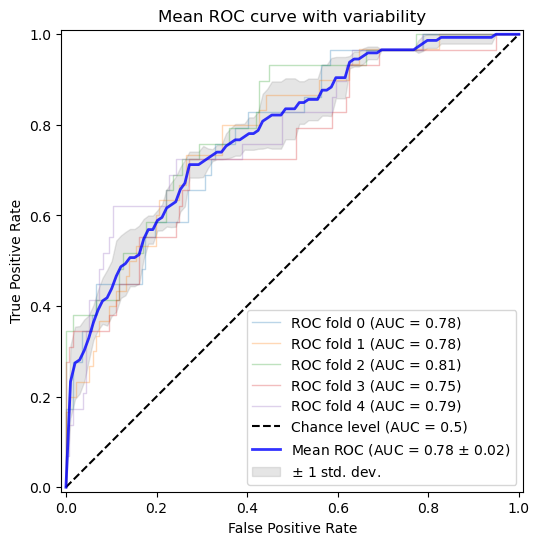

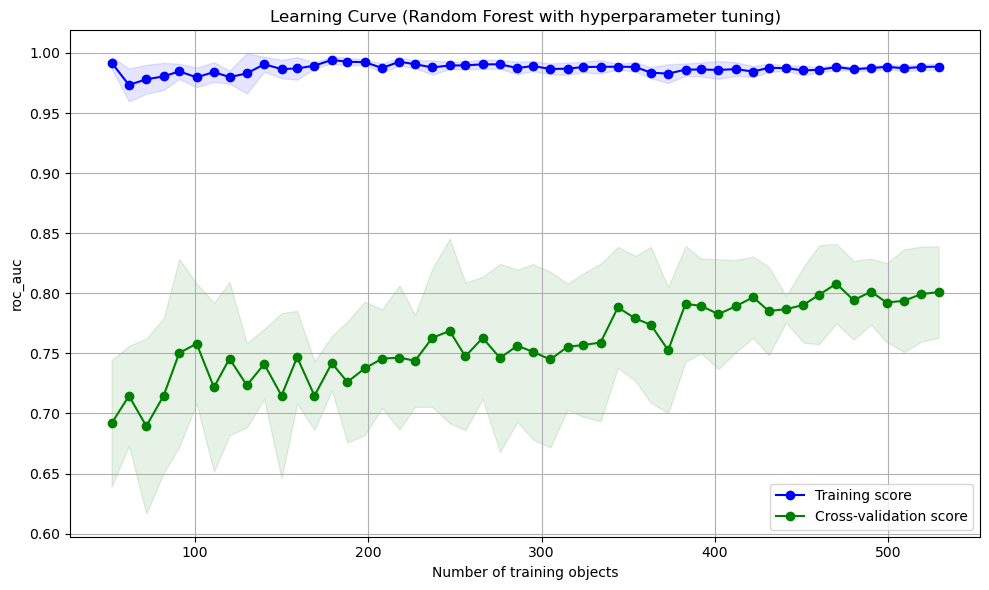

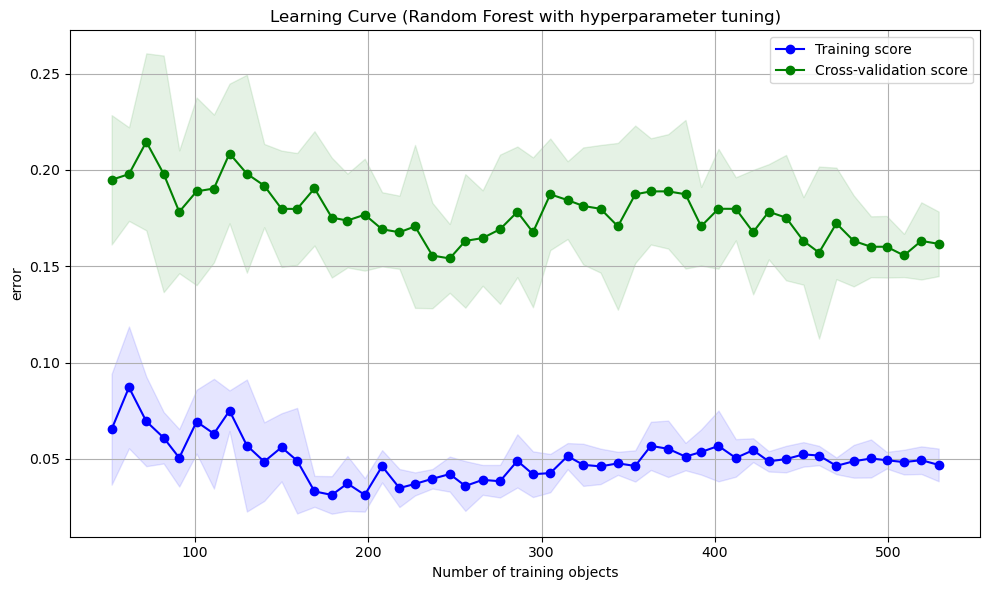

In [ ]:
# Old model with 2500 features
def optimize_rf(X_train, y_train):
    pipe = Pipeline([('feature_selection', SelectKBest(f_classif)), 
                 ('classifier', RandomForestClassifier(random_state=42, n_jobs=-1, max_features='sqrt', class_weight='balanced'))
                 ])

    param_dist = {
        'feature_selection__k': np.arange(100, 2500, 25), # [300, 400, 500, 9000],
        'classifier__n_estimators': np.arange(10, 40, 2), # [30, 40, 50],
        'classifier__min_samples_split': np.arange(10, 20, 2), # [5, 10, 15],
        'classifier__min_samples_leaf': np.arange(10, 20, 2),
        'classifier__max_depth': np.arange(6, 20, 2), # [5, 10, 15, None],
        'classifier__criterion': ['gini', 'entropy'],
        'classifier__bootstrap': [True, False]
    }

    n_iterations = 20

    random_search = RandomizedSearchCV(
                                        pipe, 
                                        param_distributions=param_dist, 
                                        cv=StratifiedKFold(n_splits=5, shuffle=True, random_state=42), 
                                        n_iter=n_iterations,
                                        scoring='roc_auc', 
                                        n_jobs=-1,
                                        random_state=42
                                        )
    random_search.fit(X_train, y_train)

    print("Best Parameters:", random_search.best_params_)
    print("Best Score:", random_search.best_score_)
    return random_search.best_estimator_

X = data.iloc[:,:-1]
y = data.iloc[:,-1]

X_train, y_train, best_classifier = plot_roc_cv(X, y, n_splits=5)
plot_learning_curve(X_train, y_train, best_classifier, scoring='roc_auc', clf_type='Random Forest with hyperparameter tuning')
plot_learning_curve(X_train, y_train, best_classifier, scoring='error', clf_type='Random Forest with hyperparameter tuning')


Best Parameters: {'feature_selection__k': 350, 'classifier__n_estimators': 15, 'classifier__min_samples_split': 25, 'classifier__min_samples_leaf': 40, 'classifier__max_depth': 10, 'classifier__criterion': 'gini', 'classifier__bootstrap': False}
Best Score: 0.7906897415631294
Accuracy:  0.729
Precision: 0.300
Recall:    0.414
F1 Score:  0.348
AUC Score: 0.736
Best Parameters: {'feature_selection__k': 350, 'classifier__n_estimators': 15, 'classifier__min_samples_split': 25, 'classifier__min_samples_leaf': 40, 'classifier__max_depth': 10, 'classifier__criterion': 'gini', 'classifier__bootstrap': False}
Best Score: 0.7665669458848557
Accuracy:  0.729
Precision: 0.364
Recall:    0.667
F1 Score:  0.471
AUC Score: 0.829
Best Parameters: {'feature_selection__k': 900, 'classifier__n_estimators': 15, 'classifier__min_samples_split': 40, 'classifier__min_samples_leaf': 40, 'classifier__max_depth': 10, 'classifier__criterion': 'gini', 'classifier__bootstrap': False}
Best Score: 0.796277090812392


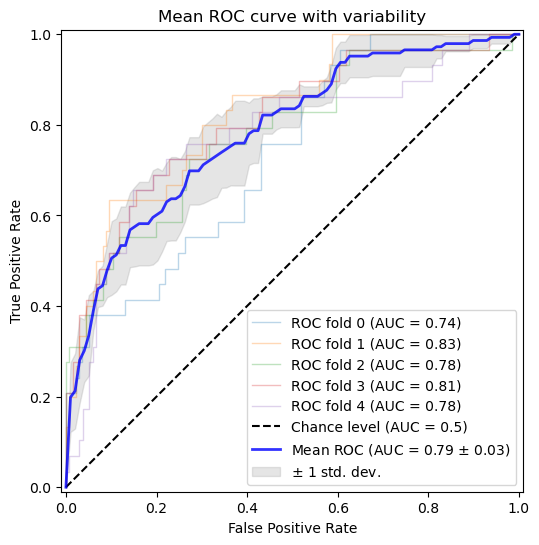

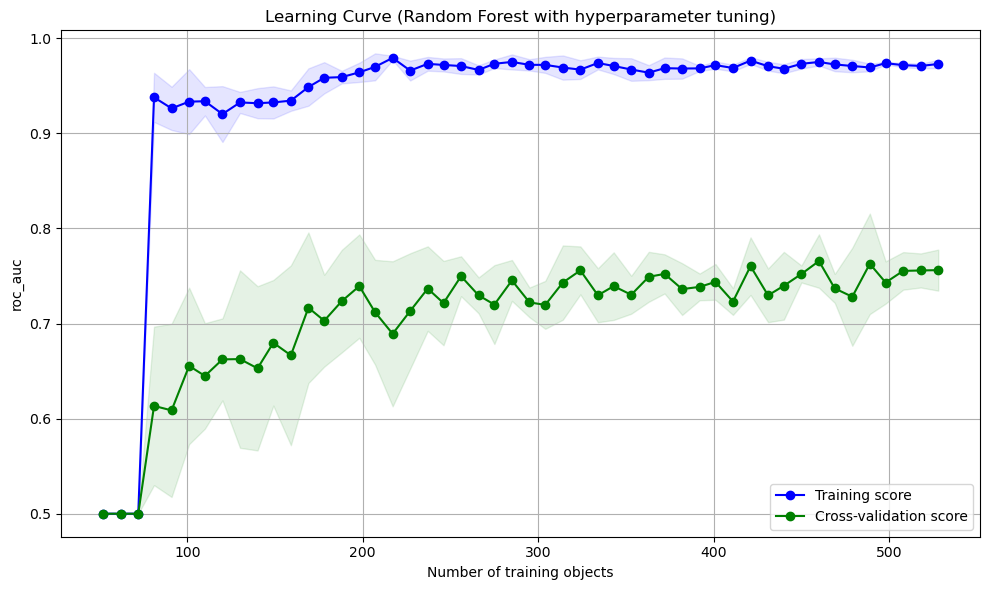

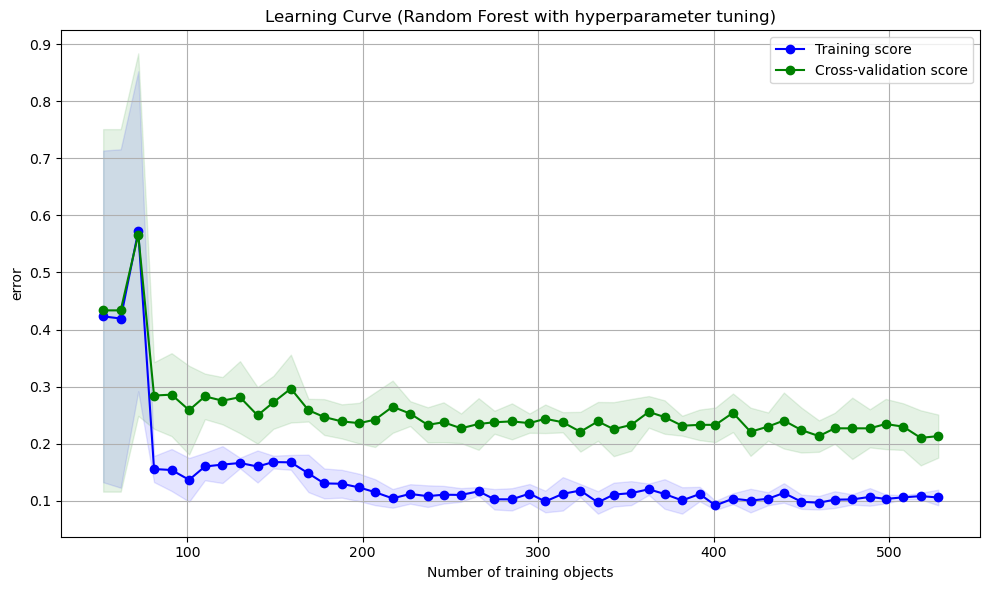

In [ ]:
# Old model with 1000 features
def optimize_rf(X_train, y_train):
    pipe = Pipeline([('feature_selection', SelectKBest(f_classif)), 
                 ('classifier', RandomForestClassifier(random_state=42, n_jobs=-1, max_features='sqrt', class_weight='balanced'))
                 ])

    param_dist = {
        'feature_selection__k': np.arange(100, 1000, 50),
        'classifier__n_estimators': np.arange(5, 20, 5),
        'classifier__min_samples_split': np.arange(20, 50, 5),
        'classifier__min_samples_leaf': np.arange(20, 50, 5),
        'classifier__max_depth': [5, 10],
        'classifier__criterion': ['gini', 'entropy'],
        'classifier__bootstrap': [True, False]
    }

    n_iterations = 20

    random_search = RandomizedSearchCV(
                                        pipe, 
                                        param_distributions=param_dist, 
                                        cv=StratifiedKFold(n_splits=5, shuffle=True, random_state=42), 
                                        n_iter=n_iterations,
                                        scoring='roc_auc', 
                                        n_jobs=-1,
                                        random_state=42
                                        )
    random_search.fit(X_train, y_train)

    print("Best Parameters:", random_search.best_params_)
    print("Best Score:", random_search.best_score_)
    return random_search.best_estimator_

X = data.iloc[:,:-1]
y = data.iloc[:,-1]

X_train, y_train, best_classifier = plot_roc_cv(X, y, n_splits=5)
plot_learning_curve(X_train, y_train, best_classifier, scoring='roc_auc', clf_type='Random Forest with hyperparameter tuning')
plot_learning_curve(X_train, y_train, best_classifier, scoring='error', clf_type='Random Forest with hyperparameter tuning')

A model with an additional hyperparameter (min_impurity_decrease) was tested to see whether the overfitting could be limited. However the learning curve does not show a significant improvement.

Best Parameters: {'feature_selection__k': 110, 'classifier__n_estimators': 15, 'classifier__min_samples_split': 30, 'classifier__min_samples_leaf': 30, 'classifier__min_impurity_decrease': 0.001, 'classifier__max_depth': 5, 'classifier__criterion': 'entropy', 'classifier__bootstrap': False}
Best Score: 0.7738313586156292
Accuracy:  0.813
Precision: 0.472
Recall:    0.586
F1 Score:  0.523
AUC Score: 0.830
Best Parameters: {'feature_selection__k': 160, 'classifier__n_estimators': 10, 'classifier__min_samples_split': 40, 'classifier__min_samples_leaf': 30, 'classifier__min_impurity_decrease': 0.01, 'classifier__max_depth': 5, 'classifier__criterion': 'gini', 'classifier__bootstrap': True}
Best Score: 0.7702566148118601
Accuracy:  0.801
Precision: 0.463
Recall:    0.633
F1 Score:  0.535
AUC Score: 0.806
Best Parameters: {'feature_selection__k': 140, 'classifier__n_estimators': 15, 'classifier__min_samples_split': 20, 'classifier__min_samples_leaf': 30, 'classifier__min_impurity_decrease': 

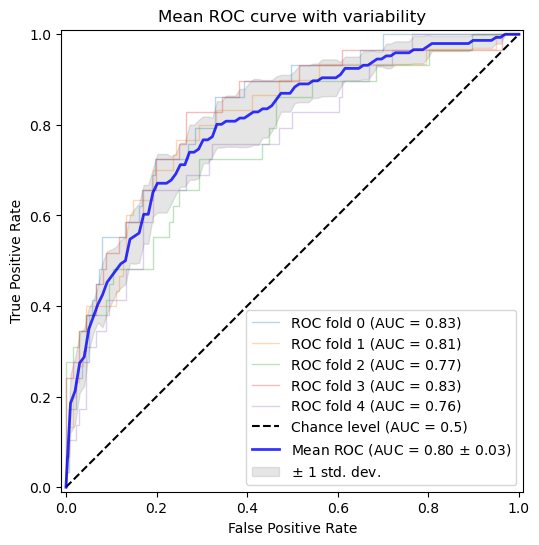

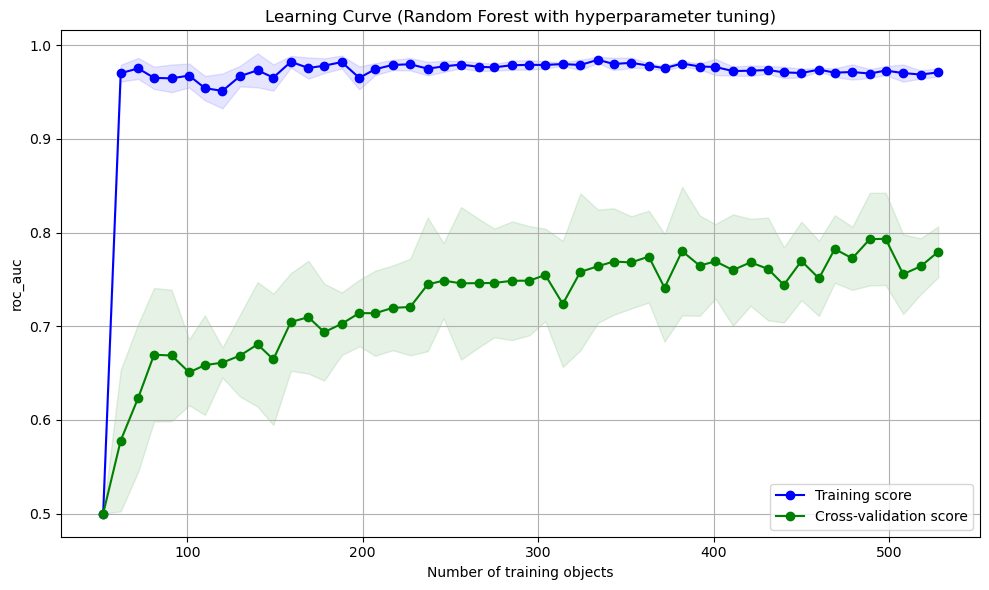

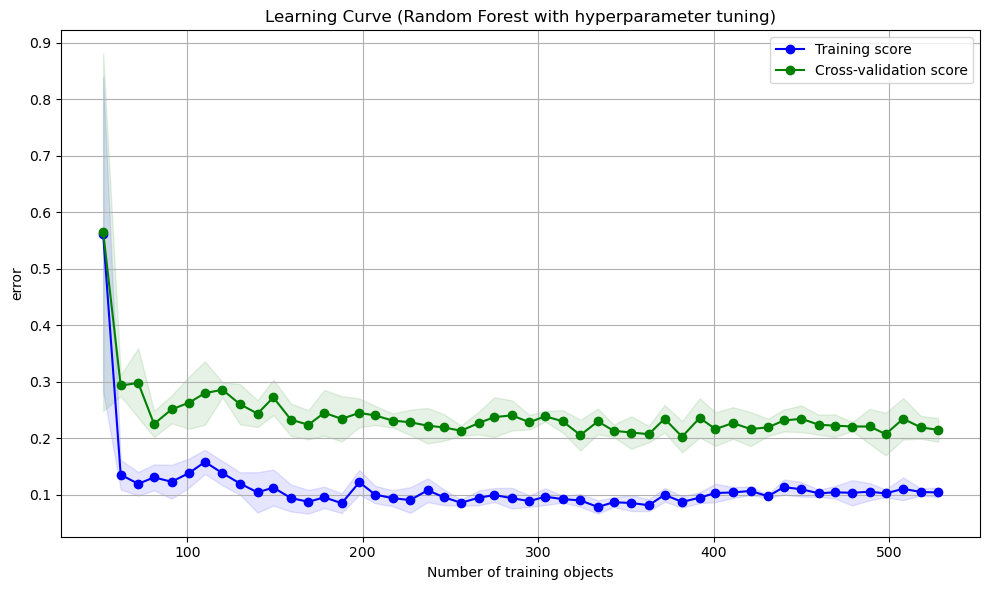

In [56]:
def optimize_rf(X_train, y_train):
    pipe = Pipeline([('feature_selection', SelectKBest(f_classif)), 
                 ('classifier', RandomForestClassifier(random_state=42, n_jobs=-1, max_features='sqrt', class_weight='balanced'))
                 ])

    param_dist = {
        'feature_selection__k': np.arange(50, 250, 10),
        'classifier__n_estimators': np.arange(5, 20, 5),
        'classifier__min_samples_split': np.arange(20, 50, 5),
        'classifier__min_samples_leaf': np.arange(20, 50, 5),
        'classifier__max_depth': [5, 10],
        'classifier__criterion': ['gini', 'entropy'],
        'classifier__bootstrap': [True, False],
        'classifier__min_impurity_decrease': [0.0001, 0.001, 0.01, 0.1]
    }

    n_iterations = 20

    random_search = RandomizedSearchCV(
                                        pipe, 
                                        param_distributions=param_dist, 
                                        cv=StratifiedKFold(n_splits=5, shuffle=True, random_state=42), 
                                        n_iter=n_iterations,
                                        scoring='roc_auc', 
                                        n_jobs=-1,
                                        random_state=42
                                        )
    random_search.fit(X_train, y_train)

    print("Best Parameters:", random_search.best_params_)
    print("Best Score:", random_search.best_score_)
    return random_search.best_estimator_

X = data.iloc[:,:-1]
y = data.iloc[:,-1]

X_train, y_train, best_classifier = plot_roc_cv(X, y, n_splits=5)
plot_learning_curve(X_train, y_train, best_classifier, scoring='roc_auc', clf_type='Random Forest with hyperparameter tuning')
plot_learning_curve(X_train, y_train, best_classifier, scoring='error', clf_type='Random Forest with hyperparameter tuning')